# Nursing Home COVID-19 Risk Assessment

Group 10:<br>
Marianna Carini<br>
Eric Chen<br>
Allen Lee<br>
Stella Lee<br>
Smitha Kannanaikkal


Studying nursing home data and the impact the facilities have seen from COVID-19. We include demographics data from the US Census as well as COVID policies implimented by counties. We set out to find out what is going right with nursing homes that have not seen a big impact from COVID-19 and what can be improved from nursing homes that have felt a large impact.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import plotly.express as px
from datetime import datetime
from matplotlib import dates
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import requests
from plotly.offline import init_notebook_mode, iplot
import chart_studio.plotly as py

## Importing Nursing Home Data

In [2]:
#connecting to nursing home API
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cms.gov", None)
MyAppToken = 'eXXXXXs'

# Example authenticated client (needed for non-public datasets):
client = Socrata('data.cms.gov',
                  MyAppToken,
                  username="mXXXXXXu",
                  password="XXXXXXX")

# First 350000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("s2uc-8wxp", limit = 429987)

In [3]:
# Convert to pandas DataFrame
nursinghome_df = pd.DataFrame.from_records(results)

In [4]:
rating = pd.read_csv('Star_Ratings.csv')
provider_info = pd.read_csv('NH_ProviderInfo.csv',encoding='ISO 8859-1')

### Cleaning nursing home data

In [5]:
##clean nursing home data##

#Remove unwanted columns
nursinghome_df = nursinghome_df.drop(columns=[':@computed_region_dz63_q6gx',':@computed_region_ia25_mrsk',':@computed_region_p3pw_njwh',':@computed_region_vbss_8z7g',':@computed_region_x9pa_s2gq','reporting_interval','weekly_resident_confirmed_covid_19_cases_per_1_000_residents','weekly_resident_covid_19_deaths_per_1_000_residents'])
#rename nursing home columns from API to match what we had previously in csv
old_nh_cols = ['able_to_test_or_obtain_resources_to_test_all_current_residents_within_next_7_days','able_to_test_or_obtain_resources_to_test_all_staff_and_or_personnel_within_next_7_days','any_current_supply_of_eye','any_current_supply_of_gloves','any_current_supply_of_gowns','any_current_supply_of_hand','any_current_supply_of_n95','any_current_supply_of_surgical','any_current_supply_of','county','covid_19_point_of_care_tests_performed_on_residents_since_last_report','covid_19_point_of_care_tests_performed_on_staff_and_or_personnel_since_last_report','during_past_two_weeks_average_time_to_receive_resident_test_results','during_past_two_weeks_average_time_to_receive_staff_and_or_personnel_test_results','enough_supplies_to_test_all_staff_and_or_personnel_using_point_of_care_test_machine','geolocation','has_facility_performed_resident_tests_since_last_report','has_facility_performed_staff_and_or_personnel_tests_since_last_report','in_house_point_of_care_test_machine','initial_confirmed_covid_19_case_this_week','laboratory_type_is_other','laboratory_type_is_private','laboratory_type_is_state','number_of_all_beds','number_of_ventilators_in_1','number_of_ventilators_in','one_week_supply_of_eye','one_week_supply_of_gloves','one_week_supply_of_gowns','one_week_supply_of_hand','one_week_supply_of_n95_masks','one_week_supply_of_surgical','one_week_supply_of_ventilator','passed_quality_assurance','provider_address','provider_city','provider_name','provider_state','provider_zip_code','reason_for_not_testing_residents_lack_of_access_to_laboratory','reason_for_not_testing_residents_lack_of_access_to_trained_personnel_','reason_for_not_testing_residents_lack_of_ppe_for_personnel_','reason_for_not_testing_residents_lack_of_supplies','reason_for_not_testing_residents_other','reason_for_not_testing_residents_uncertainty_about_reimbursement','reason_for_not_testing_staff_and_or_personnel_lack_of_access_to_laboratory','reason_for_not_testing_staff_and_or_personnel_lack_of_access_to_trained_personnel_','reason_for_not_testing_staff_and_or_personnel_lack_of_ppe_for_personnel_','reason_for_not_testing_staff_and_or_personnel_lack_of_supplies','reason_for_not_testing_staff_and_or_personnel_other','reason_for_not_testing_staff_and_or_personnel_uncertainty_about_reimbursement','resident_access_to_testing','residents_total_admissions','residents_total_all_deaths','residents_total_confirmed','residents_total_covid_19','residents_total_suspected','residents_weekly_admissions','residents_weekly_all_deaths','residents_weekly_confirmed','residents_weekly_covid_19','residents_weekly_suspected','shortage_of_aides','shortage_of_clinical_staff','shortage_of_nursing_staff','shortage_of_other_staff','staff_total_confirmed_covid','staff_total_covid_19_deaths','staff_total_suspected_covid','staff_weekly_confirmed_covid','staff_weekly_covid_19_deaths','staff_weekly_suspected_covid','submitted_data','tested_another_subgroup_of_residents','tested_another_subgroup_of_staff_and_or_personnel','tested_asymptomatic_residents_facility_wide_after_a_new_case','tested_asymptomatic_residents_in_a_unit_or_section_after_a_new_case','tested_asymptomatic_residents_without_known_exposure_as_surveillance','tested_asymptomatic_staff_and_or_personnel_facility_wide_after_a_new_case','tested_asymptomatic_staff_and_or_personnel_in_a_unit_or_section_after_a_new_case','tested_asymptomatic_staff_and_or_personnel_without_known_exposure_as_surveillance','tested_residents_with_new_signs_or_symptoms','tested_staff_and_or_personnel_with_new_signs_or_symptoms','three_or_more_confirmed_covid_19_cases_this_week','total_number_of_occupied','total_resident_confirmed_covid_19_cases_per_1_000_residents','total_resident_covid_19_deaths_per_1_000_residents','total_residents_covid_19_deaths_as_a_percentage_of_confirmed_covid_19_cases','ventilator_dependent_unit','federal_provider_number','week_ending']
new_nh_cols = ['Able to Test or Obtain Resources to Test All Current Residents Within Next 7 Days','Able to Test or Obtain Resources to Test All Staff and/or Personnel Within Next 7 Days','Any Current Supply of Eye Protection','Any Current Supply of Gloves','Any Current Supply of Gowns','Any Current Supply of Hand Sanitizer','Any Current Supply of N95 Masks','Any Current Supply of Surgical Masks','Any Current Supply of Ventilator Supplies','County','COVID-19 Point-of-Care Tests Performed on Residents Since Last Report','COVID-19 Point-of-Care Tests Performed on Staff and/or Personnel Since Last Report','During Past Two Weeks Average Time to Receive Resident Test Results','During Past Two Weeks Average Time to Receive Staff and/or Personnel Test Results','Enough Supplies to Test All Staff and/or Personnel Using Point-of-Care Test Machine','Geolocation','Has Facility Performed Resident Tests Since Last Report','Has Facility Performed Staff and/or Personnel Tests Since Last Report','In-House Point-of-Care Test Machine','Initial Confirmed COVID-19 Case This Week','Laboratory Type Is Other','Laboratory Type Is Private Lab','Laboratory Type Is State Health Dept','Number of All Beds','Number of Ventilators in Use for COVID-19','Number of Ventilators in Facility','One-Week Supply of Eye Protection','One-Week Supply of Gloves','One-Week Supply of Gowns','One-Week Supply of Hand Sanitizer','One-Week Supply of N95 Masks','One-Week Supply of Surgical Masks','One-Week Supply of Ventilator Supplies','Passed Quality Assurance Check','Provider Address','Provider City','Provider Name','Provider State','Provider Zip Code','Reason for Not Testing Residents - Lack of Access to Laboratory','Reason for Not Testing Residents - Lack of Access to Trained Personnel ','Reason for Not Testing Residents - Lack of PPE for Personnel ','Reason for Not Testing Residents - Lack of Supplies','Reason for Not Testing Residents - Other','Reason for Not Testing Residents - Uncertainty About Reimbursement','Reason for Not Testing Staff and/or Personnel - Lack of Access to Laboratory','Reason for Not Testing Staff and/or Personnel - Lack of Access to Trained Personnel ','Reason for Not Testing Staff and/or Personnel - Lack of PPE for Personnel ','Reason for Not Testing Staff and/or Personnel - Lack of Supplies','Reason for Not Testing Staff and/or Personnel - Other','Reason for Not Testing Staff and/or Personnel - Uncertainty About Reimbursement','Resident Access to Testing in Facility','Residents Total Admissions COVID-19','Residents Total All Deaths','Residents Total Confirmed COVID-19','Residents Total COVID-19 Deaths','Residents Total Suspected COVID-19','Residents Weekly Admissions COVID-19','Residents Weekly All Deaths','Residents Weekly Confirmed COVID-19','Residents Weekly COVID-19 Deaths','Residents Weekly Suspected COVID-19','Shortage of Aides','Shortage of Clinical Staff','Shortage of Nursing Staff','Shortage of Other Staff','Staff Total Confirmed COVID-19','Staff Total COVID-19 Deaths','Staff Total Suspected COVID-19','Staff Weekly Confirmed COVID-19','Staff Weekly COVID-19 Deaths','Staff Weekly Suspected COVID-19','Submitted Data','Tested Another Subgroup of Residents','Tested Another Subgroup of Staff and/or Personnel','Tested Asymptomatic Residents Facility-Wide After a New Case','Tested Asymptomatic Residents in a Unit or Section After a New Case','Tested Asymptomatic Residents Without Known Exposure as Surveillance','Tested Asymptomatic Staff and/or Personnel Facility-Wide After a New Case','Tested Asymptomatic Staff and/or Personnel in a Unit or Section After a New Case','Tested Asymptomatic Staff and/or Personnel Without Known Exposure as Surveillance','Tested Residents with New Signs or Symptoms','Tested Staff and/or Personnel with New Signs or Symptoms','Three or More Confirmed COVID-19 Cases This Week','Total Number of Occupied Beds','Total Resident Confirmed COVID-19 Cases Per 1,000 Residents','Total Resident COVID-19 Deaths Per 1,000 Residents','Total Residents COVID-19 Deaths as a Percentage of Confirmed COVID-19 Cases','Ventilator Dependent Unit','Federal Provider Number','Week Ending']
nursinghome_df.rename(columns = dict(zip(old_nh_cols,new_nh_cols)),inplace = True)
#add columns
nursinghome_df['ID1'] = nursinghome_df[['County','Provider State']].agg(''.join, axis = 1)
nursinghome_df['ID2'] = nursinghome_df[['County','Provider State','Week Ending']].agg(''.join, axis = 1)
nursinghome_df = nursinghome_df.loc[nursinghome_df['Week Ending']<='2020-10-11T00:00:00.000',:].reset_index(drop=True)
nursinghome_df.head()

Week Ending Federal Provider Number  \
0  2020-05-24T00:00:00.000                  105384   
1  2020-05-24T00:00:00.000                  105432   
2  2020-05-24T00:00:00.000                  105460   
3  2020-05-24T00:00:00.000                  105624   
4  2020-05-24T00:00:00.000                  105632   

                                     Provider Name       Provider Address  \
0                                   CALUSA HARBOUR          2525 FIRST ST   
1                            RIVERSIDE CARE CENTER      899 NW 4TH STREET   
2  NORTH FLORIDA REHABILITATION AND SPECIALTY CARE     6700 NW 10TH PLACE   
3                 BONIFAY NURSING AND REHAB CENTER  306 WEST BROCK AVENUE   
4                  HARTS HARBOR HEALTH CARE CENTER         11565 HARTS RD   

  Provider City Provider State Provider Zip Code Submitted Data      County  \
0    FORT MYERS             FL             33901              N         Lee   
1         MIAMI             FL             33128              N  Miami-Dade   
2   GAINESVILLE             FL             32605              N     Alachua   
3       BONIFAY             FL             32425              N      Holmes   
4  JACKSONVILLE             FL             32218              N       Duval   

                                         Geolocation  ...  \
0  {'type': 'Point', 'coordinates': [-81.864238, ...  ...   
1  {'type': 'Point', 'coordinates': [-80.209013, ...  ...   
2  {'type': 'Point', 'coordinates': [-82.413587, ...  ...   
3  {'type': 'Point', 'coordinates': [-85.683806, ...  ...   
4  {'type': 'Point', 'coordinates': [-81.657236, ...  ...   

  Tested Asymptomatic Staff and/or Personnel Without Known Exposure as Surveillance  \
0                                                NaN                                  
1                                                NaN                                  
2                                                NaN                                  
3                                                NaN                                  
4                                                NaN                                  

  Tested Another Subgroup of Staff and/or Personnel  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   

  In-House Point-of-Care Test Machine  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   

  Enough Supplies to Test All Staff and/or Personnel Using Point-of-Care Test Machine  \
0                                                NaN                                    
1                                                NaN                                    
2                                                NaN                                    
3                                                NaN                                    
4                                                NaN                                    

  Number of Ventilators in Facility Number of Ventilators in Use for COVID-19  \
0                               NaN                                       NaN   
1                               NaN                                       NaN   
2                               NaN                                       NaN   
3                               NaN                                       NaN   
4                               NaN                                       NaN   

  Any Current Supply of Ventilator Supplies  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                          

In [6]:
#rating.info()

In [7]:
#provider_info.info()
provider_info_filter = provider_info[['Federal Provider Number','Ownership Type',
'Total Weighted Health Survey Score','Number of Fines','Total Amount of Fines in Dollars','Total Number of Penalties']]


provider_info_filter = pd.concat([provider_info_filter.loc[:,~(provider_info_filter.columns.isin(['Ownership Type','Provider Type']))],\
            pd.get_dummies(provider_info_filter['Ownership Type'])],axis = 1)

In [8]:
provider_info_filter.head()

Federal Provider Number  Total Weighted Health Survey Score  \
0                  015009                               5.333   
1                  015010                              18.667   
2                  015012                              30.667   
3                  015014                              12.667   
4                  015015                              14.000   

   Number of Fines  Total Amount of Fines in Dollars  \
0                0                                 0   
1                0                                 0   
2                0                                 0   
3                0                                 0   
4                2                             29611   

   Total Number of Penalties  For profit - Corporation  \
0                          0                         1   
1                          0                         1   
2                          0                         0   
3                          0                         0   
4                          2                         0   

   For profit - Individual  For profit - Limited Liability company  \
0                        0                                       0   
1                        0                                       0   
2                        0                                       0   
3                        1                                       0   
4                        1                                       0   

   For profit - Partnership  Government - City  Government - City/county  \
0                         0                  0                         0   
1                         0                  0                         0   
2                         0                  0                         0   
3                         0                  0                         0   
4                         0                  0                         0   

   Government - County  Government - Federal  Government - Hospital district  \
0                    0                     0                               0   
1                    0                     0                               0   
2                    1                     0                               0   
3                    0                     0                               0   
4                    0                     0                               0   

   Government - State  Non profit - Church related  Non profit - Corporation  \
0                   0                            0                         0   
1                   0                            0                         0   
2                   0                            0                         0   
3                   0                            0                         0   
4                   0                            0                         0   

   Non profit - Other  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [9]:
#analysing provider name, federal provider number
#checking how many provider has more than 1 nursing homeprint('Provider Name Na: ',data[['Provider Name']].isna().sum(),'Federal Provider Number: ',data['Federal Provider Number'].isna().sum())
print('Total Providers: ' , len(nursinghome_df['Provider Name'].unique()))
print('Providers Owning more than 1 NH: ',sum(nursinghome_df.groupby(['Provider Name'])['Federal Provider Number'].nunique()>1))

#check for provider who has more than one NH, are they in different state
s = nursinghome_df.loc[nursinghome_df['Provider Name'].isin(\
                                        nursinghome_df.groupby(['Provider Name'])['Federal Provider Number'].nunique().\
                                        sort_values(ascending = False)[:726].index)].\
groupby(['Provider Name'])['Provider State'].\
nunique().sort_values(ascending = False)

print('Total provider having NH in more than 1 state: ',len(s[~s.where(s>1).isna()]))

Total Providers:  15125
Providers Owning more than 1 NH:  189
Total provider having NH in more than 1 state:  170


In [10]:
#columns for clustering - 'Federal Provider Number','Provider Name'
req_col = ['Federal Provider Number','Provider Name', 'Week Ending',
'Residents Total Admissions COVID-19', 'Residents Total Confirmed COVID-19','Residents Total Suspected COVID-19',
'Residents Total All Deaths', 'Residents Total COVID-19 Deaths','Number of All Beds','Total Number of Occupied Beds',
'Laboratory Type Is State Health Dept','Laboratory Type Is Private Lab','Laboratory Type Is Other', 
'Reason for Not Testing Residents - Lack of PPE for Personnel ',
'Reason for Not Testing Residents - Lack of Supplies','Reason for Not Testing Residents  - Lack of Access to Laboratory',
'Reason for Not Testing Residents - Lack of Access to Trained Personnel ','Reason for Not Testing Residents  - Uncertainty About Reimbursement',
'Reason for Not Testing Residents  - Other','Tested Residents with New Signs or Symptoms',
'Tested Asymptomatic Residents in a Unit or Section After a New Case','Tested Asymptomatic Residents Facility-Wide After a New Case',
'Tested Asymptomatic Residents Without Known Exposure as Surveillance','Tested Another Subgroup of Residents',
'In-House Point-of-Care Test Machine','COVID-19 Point-of-Care Tests Performed on Residents Since Last Report',
'Shortage of Aides','Shortage of Other Staff','Any Current Supply of N95 Masks','One-Week Supply of N95 Masks',
'Any Current Supply of Surgical Masks','One-Week Supply of Surgical Masks',
'Any Current Supply of Eye Protection','One-Week Supply of Eye Protection',
'Any Current Supply of Gowns','One-Week Supply of Gowns',
'Any Current Supply of Gloves','One-Week Supply of Gloves','Any Current Supply of Hand Sanitizer','One-Week Supply of Hand Sanitizer',
'Ventilator Dependent Unit','Number of Ventilators in Facility','Number of Ventilators in Use for COVID-19','Any Current Supply of Ventilator Supplies',
'One-Week Supply of Ventilator Supplies','Total Resident Confirmed COVID-19 Cases Per 1,000 Residents',
'Total Resident COVID-19 Deaths Per 1,000 Residents','Total Residents COVID-19 Deaths as a Percentage of Confirmed COVID-19 Cases']

In [11]:
#I have considered mean, which will act as percentage instead of just taking sum because different NH have different records
# and also avoiding mode because Kmeans is not that apt with binary data.

#mean(percentage), can be interpreted as eg 60% time NH had supplies etc

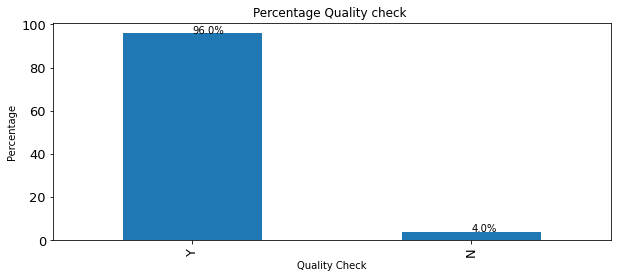

In [12]:
#lets first try clustering instances at individual NH level -


#considering only those instances which has passed the quality check 
bar_plot = round(nursinghome_df['Passed Quality Assurance Check'].value_counts(normalize = True)*100).plot(kind = 'bar',figsize=(10,4),fontsize=13)
plt.title('Percentage Quality check ')
for patch in bar_plot.patches:
    plt.text(patch.get_x()+(patch.get_width()/2),patch.get_height(),str(patch.get_height())+'%',fontsize=10)
plt.xlabel('Quality Check')
plt.ylabel('Percentage')

data_c = nursinghome_df[nursinghome_df['Passed Quality Assurance Check']=='Y'].reset_index()


In [13]:
#############################Part 1 cases - since feature represent total count hence using only the latest data - cases
old_1 = ['Residents Total Admissions COVID-19', 'Residents Total Confirmed COVID-19','Residents Total Suspected COVID-19',
'Residents Total All Deaths', 'Residents Total COVID-19 Deaths','Number of All Beds','Total Number of Occupied Beds']
new_1 = ['r_t_adm_c19','r_t_cfmd_c19','r_t_supct_c19','r_t_death','r_t_death_c19','#all_beds','#ocupd_beds']
data_c.rename(columns = dict(zip(old_1,new_1)),inplace = True)

new_1.extend(['Federal Provider Number','Week Ending'])
data_1 = data_c.loc[:,new_1].sort_values(by='Week Ending').groupby('Federal Provider Number').agg('last').reset_index()

#s = data.isna().sum().sort_values(ascending = False)
#(s[s>1]/len(data))*100

In [14]:
#########################################Part 2 cases - consider mean as the sigle entry - Lab
old_1 = ['Laboratory Type Is State Health Dept','Laboratory Type Is Private Lab','Laboratory Type Is Other']
new_1 = ['lab_state_hlth','lab_prvt','lab_othr']
data_c.rename(columns = dict(zip(old_1,new_1)),inplace = True)

replace_dict = {'Y':1,'N':0}
data_c.loc[:,new_1] = data_c.loc[:,new_1].applymap(replace_dict.get)
    
new_1.extend(['Federal Provider Number'])
data_2 = \
data_c[new_1].groupby(['Federal Provider Number']).agg('mean').reset_index()

#s = data_c.groupby(['Federal Provider Number']).lab_prvt.nunique().sort_values(ascending = False)
#print(s.value_counts())
#s = data_c.groupby(['Federal Provider Number']).lab_othr.nunique().sort_values(ascending = False)
#print(s.value_counts())

In [15]:
#########################################Part 3 cases - consider mean as the sigle entry - reason
old_1 = ['Reason for Not Testing Residents - Lack of PPE for Personnel ',
         'Reason for Not Testing Residents - Lack of Supplies',
         'Reason for Not Testing Residents - Lack of Access to Laboratory',
         'Reason for Not Testing Residents - Lack of Access to Trained Personnel ',
         'Reason for Not Testing Residents - Uncertainty About Reimbursement',
         'Reason for Not Testing Residents - Other']
new_1 = ['rsn_not_tst_lck_ppe','rsn_not_tst_lck_sup','rsn_not_tst_lck_lab','rsn_not_tst_lck_Tprsnl','rsn_not_tst_lck_rmb',
        'rsn_not_tst_othr']
data_c.rename(columns = dict(zip(old_1,new_1)),inplace = True)

replace_dict = {'Y':1,'N':0}
data_c.loc[:,new_1] = data_c.loc[:,new_1].applymap(replace_dict.get)

new_1.extend(['Federal Provider Number'])
data_3 = \
data_c[new_1].groupby(['Federal Provider Number']).agg('mean').reset_index()

In [16]:
#change column from object to float to capture mean
data_c['COVID-19 Point-of-Care Tests Performed on Residents Since Last Report'] = data_c['COVID-19 Point-of-Care Tests Performed on Residents Since Last Report'].astype('float')

In [17]:
#########################################Part 4 cases - consider mean as the sigle entry - Test
old_1 = ['Tested Residents with New Signs or Symptoms',
         'Tested Asymptomatic Residents in a Unit or Section After a New Case',
         'Tested Asymptomatic Residents Facility-Wide After a New Case',
         'Tested Asymptomatic Residents Without Known Exposure as Surveillance',
         'Tested Another Subgroup of Residents',
        'COVID-19 Point-of-Care Tests Performed on Residents Since Last Report']
new_1 = ['tstd_r_sngOsym','tstd_ar_u','tstd_ar_f','t_ar_exp','tstd_sbgrp_r','poc_test']
data_c.rename(columns = dict(zip(old_1,new_1)),inplace = True)


replace_dict = {'Y':1,'N':0}
data_c.loc[:,new_1[:-1]] = data_c.loc[:,new_1].applymap(replace_dict.get)


new_1.extend(['Federal Provider Number'])
data_4 = data_c.loc[:,new_1].groupby('Federal Provider Number').agg('mean').reset_index()


In [18]:
#########################################Part 5 cases - consider mean as the sigle entry - poc
old_1 = ['In-House Point-of-Care Test Machine']
new_1 = ['in_poc_mchne']
data_c.rename(columns = dict(zip(old_1,new_1)),inplace = True)

replace_dict = {'Y':1,'N':0}
data_c.loc[:,new_1] = data_c.loc[:,new_1].applymap(replace_dict.get)


new_1.extend(['Federal Provider Number'])
data_5 = data_c.loc[:,new_1].groupby('Federal Provider Number').agg('mean').reset_index()


In [19]:
data_c['Number of Ventilators in Facility'] = data_c['Number of Ventilators in Facility'].astype('float')
data_c['Number of Ventilators in Use for COVID-19'] = data_c['Number of Ventilators in Use for COVID-19'].astype('float')

In [20]:
#########################################Part 6 cases - consider mean as the sigle entry - supplies
old_1 = ['Shortage of Aides','Shortage of Other Staff','Shortage of Nursing Staff', 'Shortage of Clinical Staff',
    'Any Current Supply of N95 Masks','One-Week Supply of N95 Masks',
'Any Current Supply of Surgical Masks','One-Week Supply of Surgical Masks',
'Any Current Supply of Eye Protection','One-Week Supply of Eye Protection',
'Any Current Supply of Gowns','One-Week Supply of Gowns',
'Any Current Supply of Gloves','One-Week Supply of Gloves','Any Current Supply of Hand Sanitizer',
'One-Week Supply of Hand Sanitizer',
'Ventilator Dependent Unit',
'Any Current Supply of Ventilator Supplies','One-Week Supply of Ventilator Supplies',
'Number of Ventilators in Facility','Number of Ventilators in Use for COVID-19']

new_1 = ['shrtg_aides','shrtg_stff','shrtg_N_stff','shrtg_cln_stff','C_sply_95_msk','O_sply_95_msk','C_sply_sg_msk','O_sply_sg_msk',
        'C_sply_eye_prtc','O_sply_eye_prtc','C_sply_gwn','O_sply_gwn','C_sply_glv','O_sply_glv',
        'C_sply_hnd_stz','O_sply_hnd_stz','vnt_d_unt','C_sply_vnt','O_sply_vnt','num_vnt_fct','num_vnt_c19']

data_c.rename(columns = dict(zip(old_1,new_1)),inplace = True)
#data_c['num_vnt_fct'] = data_c['num_vnt_fct'].astype('float')
#data_c['num_vnt_c19'] = data_c['num_vnt_c19'].astype('float')
#data_c['C_sply_vnt'] = data_c['C_sply_vnt'].astype('float')
#data_c['O_sply_vnt'] = data_c['O_sply_vnt'].astype('float')

replace_dict = {'Y':1,'N':0}
data_c.loc[:,new_1[:-2]] = data_c.loc[:,new_1[:-2]].applymap(replace_dict.get)


new_1.extend(['Federal Provider Number'])
data_6 = data_c.loc[:,new_1].groupby('Federal Provider Number').agg('mean').reset_index()

In [21]:
#############################Part 7 cases - since feature represent total count hence using only the latest data - cases
old_1 = ['Total Resident Confirmed COVID-19 Cases Per 1,000 Residents',
'Total Resident COVID-19 Deaths Per 1,000 Residents',
'Total Residents COVID-19 Deaths as a Percentage of Confirmed COVID-19 Cases']
new_1 = ['r_cmfd_c19_p1k_r','r_death_c19_p1k_r','r_t_death_prcnt_cmfd_c19']
data_c.rename(columns = dict(zip(old_1,new_1)),inplace = True)

new_1.extend(['Federal Provider Number','Week Ending'])
data_7 = data_c.loc[:,new_1].sort_values(by='Week Ending').groupby('Federal Provider Number').agg('last').reset_index()
data_7.drop(['Week Ending'],axis = 1,inplace = True)

In [22]:
##########merging all the dervied dataframe
df_list = [data_1,data_2,data_3,data_4,data_5,data_6,data_7]
#df_list = [data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_s1,data_s2,data_s3]
def merge(df_list):
    flag= True
    c = 0
    for df in df_list:
        if(flag):
            data_temp = df
            flag = False
            continue
        data_temp = data_temp.merge(df,on='Federal Provider Number',how='inner')
    
    return(data_temp)

data_merge = merge(df_list)

In [23]:
data_merge['Week Ending'] = pd.to_datetime(data_merge['Week Ending'])

for col in data_merge.columns:
    if(data_merge[col].dtype in ['O', 'str'] and col not in ['Federal Provider Number','Week Ending','Geolocation','County','Submitted Data','Provider Name','Provider Address','Provider City','Provider State', 'ID1', 'ID2']):
        data_merge[col] = data_merge[col].astype('float')

In [24]:
#From the FAQ provided, we got to know that there were instances where as part of quality assurance, data for 
#CV19 admit, CV19 confirmed, CV19 suspect was surpressed,but allowed to keep death count. we would exclude these 
#entries as it would pass wrong pattern to algorithm

print(sum((data_merge.r_t_adm_c19==0)&(data_merge.r_t_cfmd_c19==0)&(data_merge.r_t_supct_c19==0)&\
                          (data_merge.r_t_death_c19!=0)))

data_merge = data_merge[~((data_merge.r_t_adm_c19==0)&(data_merge.r_t_cfmd_c19==0)&(data_merge.r_t_supct_c19==0)&\
                          (data_merge.r_t_death_c19!=0))].reset_index(drop = True)

28


In [25]:
####check the percentage of na in the merged dataset
prcnt_na = (data_merge.isna().sum()/len(data_merge))*100
missing_value_df = pd.DataFrame({'feature': data_merge.columns,
                                 'percent_missing': prcnt_na}).reset_index(drop=True)
print(missing_value_df[missing_value_df.percent_missing>5].sort_values(by='percent_missing',ascending = False))

#We can for sure get rid of features that has around 95% of Na values
data_merge.drop(['C_sply_vnt','O_sply_vnt','num_vnt_fct','num_vnt_c19'],axis = 1,inplace=True)


                     feature  percent_missing
45               num_vnt_c19        95.975087
42                C_sply_vnt        95.968390
44               num_vnt_fct        95.968390
43                O_sply_vnt        95.961693
48  r_t_death_prcnt_cmfd_c19        31.034021
23                  poc_test        13.246718


In [26]:
#r_t_death_prcnt_cmfd_c19
#data_merge[data_merge.r_t_death_prcnt_cmfd_c19.isna()].r_t_cfmd_c19.unique()
# We can see the confirmed case is 0, in the above na scenario , 

#FAQ stated that NH reported percentage of CV19 death with respect to  either  CV19 confirmed case or by consider
#all three cases - confirmed, suspected, admited. let see the count of NH who followed what.

print('Considered confirmed case in denominaotr: ',len(data_merge[data_merge.r_t_death_prcnt_cmfd_c19 ==(data_merge.r_t_death_c19 / data_merge.r_t_cfmd_c19)*100]),\
'Considered all three: ',len(data_merge[data_merge.r_t_death_prcnt_cmfd_c19==(data_merge.r_t_death_c19 /\
                                        (data_merge.r_t_cfmd_c19+data_merge.r_t_adm_c19+data_merge.r_t_supct_c19))*100]))

#since there are huge number of NH used different denomiator, using this feature will give wrong pattern to algo, 
#hence we will drop that column 
data_merge.drop(['r_t_death_prcnt_cmfd_c19'],axis = 1,inplace=True)


#we can create new column, where all the instance follow same denomiator - consider all 3 feature
data_merge['r_t_death_prcnt_cmfd_c19_cal'] = (data_merge.r_t_death_c19 /\
                                        (data_merge.r_t_cfmd_c19+data_merge.r_t_adm_c19+data_merge.r_t_supct_c19))*100 
data_merge.r_t_death_prcnt_cmfd_c19_cal.fillna(0,inplace = True)

Considered confirmed case in denominaotr:  5199 Considered all three:  3757


In [27]:
#poc_test
print(data_merge[data_merge.poc_test.isna()].in_poc_mchne.unique())

#when poc test is null, the value for inhouse poc machine is 0 or null. let see how many instances were there, where 
#NH had no machine and still they tested.

data_merge[(data_merge.poc_test == 1)&(data_merge.in_poc_mchne==0)]
# we see there was only one isntace where NH had no machine they tested. Thus we can conclude if no machine , no test. 
#hence wee would fill the na value for test as 0 
data_merge.poc_test.fillna(0,inplace=True)



[ 0. nan]


In [28]:
#data_merge.to_csv('NH_level_data.csv')

In [29]:
print(((data_merge.apply(lambda col: sum(col==0))/len(data_merge))*100).sort_values(ascending = False))
# we would drop the column that majorily conssists of 0 , above 90%
data_mojorily_0 = ['rsn_not_tst_lck_ppe','rsn_not_tst_lck_Tprsnl','rsn_not_tst_othr','rsn_not_tst_lck_rmb','rsn_not_tst_lck_lab','vnt_d_unt',
'rsn_not_tst_lck_sup']


#data_mojorily_0 = ['rsn_not_tst_lck_ppe','rsn_not_tst_lck_Tprsnl','rsn_not_tst_othr','rsn_not_tst_lck_rmb','rsn_not_tst_lck_lab','vnt_d_unt',
#'rsn_not_tst_lck_sup','Srsn_not_tst_lck_ppe', 'Srsn_not_tst_lck_Tprsnl', 'Srsn_not_tst_othr' , 'Srsn_not_tst_lck_rmb', 'Srsn_not_tst_lck_lab',
#'Srsn_not_tst_lck_sup']

data_merge.drop(data_mojorily_0,inplace = True,axis = 1)

rsn_not_tst_lck_ppe             99.162872
rsn_not_tst_lck_Tprsnl          98.493169
rsn_not_tst_othr                98.178409
rsn_not_tst_lck_rmb             98.044468
rsn_not_tst_lck_lab             96.457273
vnt_d_unt                       95.365658
rsn_not_tst_lck_sup             91.863113
lab_othr                        89.907581
shrtg_cln_stff                  79.540584
tstd_ar_u                       74.959818
tstd_sbgrp_r                    72.254219
shrtg_stff                      65.751406
tstd_r_sngOsym                  60.259845
shrtg_N_stff                    58.545406
poc_test                        57.400214
shrtg_aides                     54.473614
r_t_death_c19                   54.205733
r_t_death_prcnt_cmfd_c19_cal    54.205733
r_death_c19_p1k_r               54.045004
tstd_ar_f                       48.151621
r_t_adm_c19                     47.254219
lab_state_hlth                  43.390035
r_t_supct_c19                   38.621752
r_t_cfmd_c19                    31

In [30]:
#lets check again the percentage of NA value present 
((data_merge.isna().sum()/len(data_merge))*100).sort_values(ascending=False)

in_poc_mchne                    0.435307
tstd_r_sngOsym                  0.267881
tstd_ar_u                       0.267881
tstd_ar_f                       0.267881
t_ar_exp                        0.267881
tstd_sbgrp_r                    0.267881
r_cmfd_c19_p1k_r                0.160729
r_death_c19_p1k_r               0.160729
lab_state_hlth                  0.060273
lab_prvt                        0.060273
lab_othr                        0.060273
shrtg_cln_stff                  0.046879
shrtg_aides                     0.046879
shrtg_stff                      0.046879
shrtg_N_stff                    0.046879
C_sply_95_msk                   0.046879
O_sply_eye_prtc                 0.046879
O_sply_hnd_stz                  0.046879
C_sply_hnd_stz                  0.046879
O_sply_glv                      0.046879
C_sply_glv                      0.046879
O_sply_gwn                      0.046879
C_sply_gwn                      0.046879
C_sply_eye_prtc                 0.046879
O_sply_sg_msk   

In [31]:
#since now we have hardly have any NA we would impute 0 
data_merge.fillna(0,inplace = True)

In [32]:
#merge NH rating , merge overall rating
data_merge = data_merge.merge(rating[['Federal Provider Number','Overall Rating']], on= 'Federal Provider Number',how='inner')

In [33]:
#merge provider info
data_merge = data_merge.merge(provider_info_filter, on='Federal Provider Number', how = 'inner')

In [34]:
temp = data_merge.corr().unstack().sort_values().reset_index()[::2]
temp.columns = ['feature_1','feature_2','corr_val']

temp[~(temp.feature_1==temp.feature_2)&(temp.corr_val>0.7)].sort_values(by='corr_val',ascending = False)

feature_1        feature_2  corr_val
2860  Total Number of Penalties  Number of Fines  0.931766
2858                #ocupd_beds        #all_beds  0.909235
2856                shrtg_aides     shrtg_N_stff  0.857788
2854            C_sply_eye_prtc       C_sply_gwn  0.854632
2852                 C_sply_gwn    C_sply_sg_msk  0.847564
2850              C_sply_sg_msk  C_sply_eye_prtc  0.824948
2848            O_sply_eye_prtc    O_sply_sg_msk  0.822529
2846              O_sply_sg_msk       O_sply_gwn  0.798620
2844            O_sply_eye_prtc       O_sply_gwn  0.768626
2842                 C_sply_glv   C_sply_hnd_stz  0.761951
2840              O_sply_95_msk       O_sply_gwn  0.742611
2838              C_sply_95_msk  C_sply_eye_prtc  0.729166
2836               r_t_cfmd_c19    r_t_death_c19  0.713338
2834             O_sply_hnd_stz       O_sply_glv  0.708026
2832              O_sply_95_msk    O_sply_sg_msk  0.701649

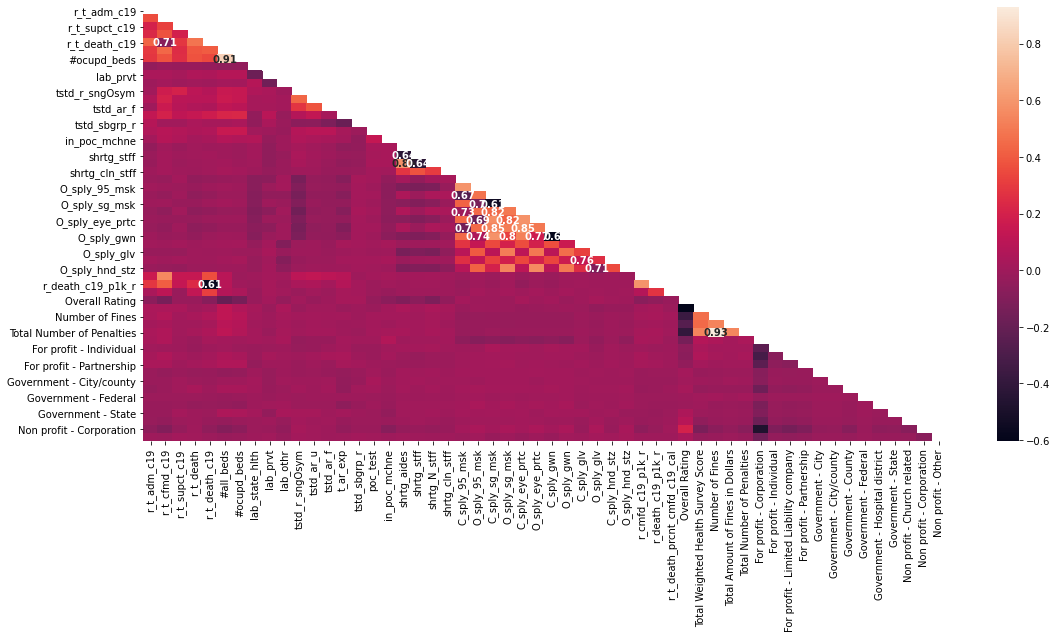

In [35]:
plt.figure(figsize=(18,8))
mask = np.zeros_like(data_merge.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data_merge.corr(),annot=False,mask = mask)
sns.heatmap(data_merge.corr(),annot=True,mask = mask|(data_merge.corr()<0.6),annot_kws={"weight": "bold"}, cbar=False)
plt.show()

In [36]:
#From above corelation we can see that Total Number of Penalties and Number of Fines gives same
#information hence we would keep only Total Number of Penalties
data_merge.drop(['Number of Fines'],inplace = True,axis = 1)

In [37]:
data_merge.loc[:,~data_merge.columns.isin(['Federal Provider Number','Week Ending'])].apply(lambda x: [x.min(),x.max()])

r_t_adm_c19  r_t_cfmd_c19  r_t_supct_c19  r_t_death  r_t_death_c19  \
0          0.0           0.0            0.0        0.0            0.0   
1        386.0         318.0          603.0      977.0          145.0   

   #all_beds  #ocupd_beds  lab_state_hlth  lab_prvt  lab_othr  ...  \
0        0.0          0.0             0.0       0.0       0.0  ...   
1      815.0        716.0             1.0       1.0       1.0  ...   

   For profit - Partnership  Government - City  Government - City/county  \
0                         0                  0                         0   
1                         1                  1                         1   

   Government - County  Government - Federal  Government - Hospital district  \
0                    0                     0                               0   
1                    1                     1                               1   

   Government - State  Non profit - Church related  Non profit - Corporation  \
0                   0                            0                         0   
1                   1                            1                         1   

   Non profit - Other  
0                   0  
1                   1  

[2 rows x 53 columns]

In [38]:
data_merge.fillna(0,inplace = True)
data_merge_bf_std = data_merge.copy()

## Nursing Home EDA

In [39]:
# Which State has the highest (and lowest) number of Nursing Facilities
states = nursinghome_df["Provider State"].value_counts()
states = pd.DataFrame(states).reset_index()
states.columns = ['States', 'Count']
print(states)

   States  Count
0      TX  25481
1      CA  24942
2      OH  20037
3      IL  15019
4      FL  14748
5      PA  14487
6      NY  12971
7      IN  11208
8      MO  10931
9      MI   9185
10     IA   9082
11     NC   8969
12     MA   7853
13     MN   7707
14     NJ   7623
15     GA   7503
16     WI   7413
17     KS   6865
18     TN   6636
19     OK   6258
20     VA   6006
21     KY   5977
22     LA   5817
23     AL   4803
24     MD   4746
25     CO   4725
26     AR   4704
27     CT   4452
28     MS   4284
29     WA   4264
30     NE   4116
31     SC   3975
32     AZ   3045
33     OR   2710
34     WV   2566
35     SD   2184
36     UT   2037
37     ME   1953
38     ID   1722
39     ND   1680
40     RI   1672
41     NH   1554
42     NM   1470
43     MT   1470
44     NV   1386
45     DE    971
46     HI    909
47     WY    759
48     VT    735
49     AK    419
50     DC    399
51     PR    126
52     GU     21


In [40]:
scl = [[0.0, 'rgb(248,255,206)'],[0.2, 'rgb(203,255,205)'],[0.4, 'rgb(155,255,164)'], [0.6, 'rgb(79,255,178)'],[0.8, 'rgb(15,183,132)'], [1, '#008059']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = states.States,
        z = states.Count,
        locationmode = 'USA-states',
        text = states.States,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Facilities in Different States")
        )
       ]

layout = dict(
        title = 'Nursing Facilities in Different States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa'),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

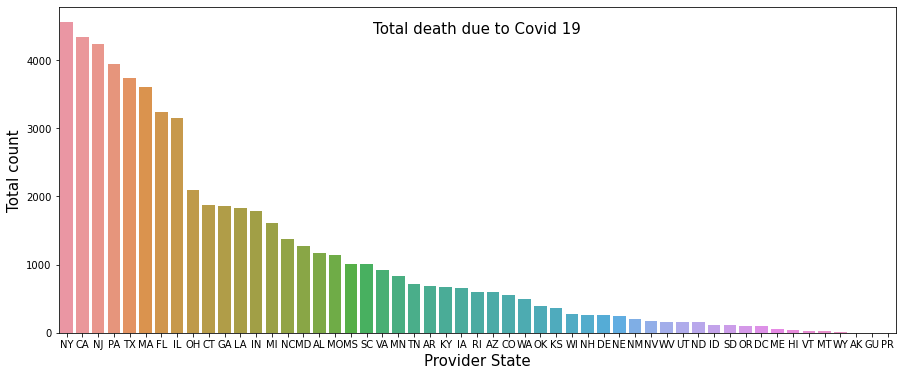

In [41]:
#covid deaths by state in nursing homes
plt.figure(figsize=(15,6))
plt.rc('axes', titlesize=15, labelsize=15)
nursinghome_df['Residents Weekly COVID-19 Deaths'] = nursinghome_df['Residents Weekly COVID-19 Deaths'].astype('float')
temp = nursinghome_df.groupby(['Provider State'])['Residents Weekly COVID-19 Deaths'].sum().sort_values(ascending= False).reset_index()
sns.barplot(x=temp['Provider State'], y=temp['Residents Weekly COVID-19 Deaths'])
plt.ylabel('Total count')
plt.title('Total death due to Covid 19',y=0.9)
plt.show()

In [42]:
data_c['Residents Weekly Confirmed COVID-19'] = data_c['Residents Weekly Confirmed COVID-19'].astype('float')
data_c['Residents Weekly COVID-19 Deaths'] = data_c['Residents Weekly COVID-19 Deaths'].astype('float')
data_c['Week Ending'] = pd.to_datetime(data_c['Week Ending'])

In [43]:
#nursing home covid rates over time
temp = data_c.sort_values(by=['Week Ending']).groupby(['Provider State','Week Ending']).\
agg({'Residents Weekly Confirmed COVID-19':'sum','Residents Weekly COVID-19 Deaths':'sum'}).reset_index()
temp['Week Ending'] = pd.to_datetime(temp['Week Ending'])
temp['Month-date'] = temp['Week Ending'].dt.strftime('%B-%d')
fig = go.Figure(data=px.choropleth(
    locations=temp['Provider State'], # Spatial coordinates
    color = temp['Residents Weekly Confirmed COVID-19'], # Data to be color-coded
    animation_frame =temp['Month-date'],
    locationmode = 'USA-states', # set of locations match entries in `locations`
    #colorscale = 'Reds',
    color_continuous_scale='reds'#"Viridis"
    #colorbar_title = "Total CV19 confirmed cases",
))
fig.update_layout(
    title_text = 'CV19 confirmed cases among nursing home residents',
    geo_scope='usa', # limite map scope to USA
    coloraxis_colorbar = dict(title="Total CV19 confirmed cases")
)
fig.show()

In [44]:
#nursing home covid deaths over time
temp = data_c.sort_values(by=['Week Ending']).groupby(['Provider State','Week Ending']).\
agg({'Residents Weekly Confirmed COVID-19':'sum','Residents Weekly COVID-19 Deaths':'sum'}).reset_index()
temp['Week Ending'] = pd.to_datetime(temp['Week Ending'])
temp['Month-date'] = temp['Week Ending'].dt.strftime('%B-%d')
fig = go.Figure(data=px.choropleth(
    locations=temp['Provider State'], # Spatial coordinates
    color = temp['Residents Weekly COVID-19 Deaths'], # Data to be color-coded
    animation_frame =temp['Month-date'],
    locationmode = 'USA-states', # set of locations match entries in `locations`
    #colorscale = 'Reds',
    color_continuous_scale='greys'#"Viridis"
    #colorbar_title = "Total CV19 confirmed cases",
))
fig.update_layout(
    title_text = 'CV19 confirmed deaths among nursing home residents',
    geo_scope='usa', # limite map scope to USA
    coloraxis_colorbar = dict(title="Total CV19 confirmed cases")
)
fig.show()



# K-means Clustering

In [45]:
# lets standardise the column before feeding it into clustering
data_merge.loc[:,~data_merge.columns.isin(['Federal Provider Number','Week Ending'])].apply(lambda x: [x.min(),x.max()])

col_to_std = ['r_t_adm_c19', 'r_t_cfmd_c19', 'r_t_supct_c19','r_t_death','r_t_death_c19','#all_beds',
              '#ocupd_beds','poc_test','r_cmfd_c19_p1k_r','r_death_c19_p1k_r','r_t_death_prcnt_cmfd_c19_cal','Overall Rating',
             'Total Weighted Health Survey Score','Total Amount of Fines in Dollars','Total Number of Penalties']


#col_to_std = ['r_t_adm_c19', 'r_t_cfmd_c19', 'r_t_supct_c19','r_t_death','r_t_death_c19','#all_beds',
#              '#ocupd_beds','poc_test','r_cmfd_c19_p1k_r','r_death_c19_p1k_r','r_t_death_prcnt_cmfd_c19_cal','Overall Rating',
#             'S_t_cfmd_c19','S_t_supct_c19','S_t_death_c19']

#col_to_std = ['#all_beds','#ocupd_beds','poc_test','r_cmfd_c19_p1k_r','r_death_c19_p1k_r','r_t_death_prcnt_cmfd_c19_cal']

data_merge[col_to_std] = StandardScaler().fit_transform(data_merge[col_to_std])
#data_merge[col_to_std] = MinMaxScaler().fit_transform(data_merge[col_to_std])


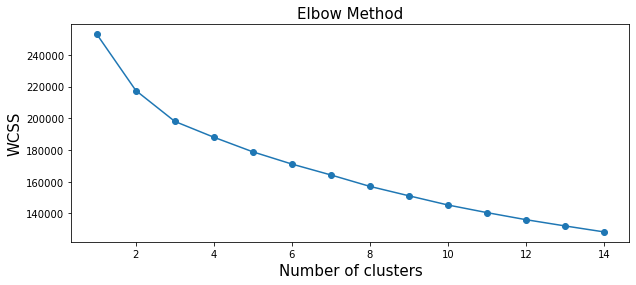

In [46]:

wcss = []
for i in range(1, 15):

    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    kmeans.fit(data_merge.loc[:,~data_merge.columns.isin(['Federal Provider Number','Week Ending'])])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 4))
plt.plot(range(1, 15), wcss,marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [47]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(data_merge.loc[:,~data_merge.columns.isin(['Federal Provider Number','Week Ending'])])

#data_merge['cluster'] = pred_y
#data_merge['cluster'] = data_merge['cluster'].astype(str) 


#lookup label
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
look_up_table = np.zeros_like(idx)
look_up_table[idx] = [2,0,1]
data_merge['cluster'] = look_up_table[kmeans.labels_]
data_merge['cluster'] = data_merge['cluster'].astype(str) 

In [48]:
data_merge.cluster.value_counts()

2    10123
1     2877
0     1900
Name: cluster, dtype: int64

In [49]:
#using original value for standardised column for further analysis

col_to_std = ['r_t_adm_c19', 'r_t_cfmd_c19', 'r_t_supct_c19','r_t_death','r_t_death_c19','#all_beds',
              '#ocupd_beds','poc_test','r_cmfd_c19_p1k_r','r_death_c19_p1k_r','r_t_death_prcnt_cmfd_c19_cal','Overall Rating',
             'Total Weighted Health Survey Score','Total Amount of Fines in Dollars','Total Number of Penalties']

temp_col = col_to_std + ['Federal Provider Number']
data_merge_bf_std_c = data_merge.drop(col_to_std,axis=1).merge(data_merge_bf_std[temp_col], on ='Federal Provider Number',
                how='inner')

data_merge_bf_std_c = data_merge_bf_std_c.merge(data_c[['Federal Provider Number','Provider Address', 'Provider City', 'Provider State','Provider Zip Code','County']].drop_duplicates(),\
                         on='Federal Provider Number',how='left')

In [50]:
data_merge_bf_std_c.loc[:,['cluster','r_cmfd_c19_p1k_r','r_death_c19_p1k_r', 'r_t_death_prcnt_cmfd_c19_cal']].\
groupby('cluster').describe()

r_cmfd_c19_p1k_r                                                     \
                   count        mean         std  min    25%    50%     75%   
cluster                                                                       
0                 1900.0  194.619105  265.533853  0.0    0.0   54.8  322.15   
1                 2877.0  635.044630  899.847633  0.0  332.2  585.0  824.60   
2                10123.0  118.531088  210.911854  0.0    0.0   21.7  139.50   

                 r_death_c19_p1k_r              ...                 \
             max             count        mean  ...    75%     max   
cluster                                         ...                  
0         1838.7            1900.0   35.917368  ...   47.6   672.7   
1        39000.0            2877.0  179.397880  ...  225.5  6500.0   
2         3000.0           10123.0   18.562798  ...   16.7   600.0   

        r_t_death_prcnt_cmfd_c19_cal                                       \
                               count       mean        std  min       25%   
cluster                                                                     
0                             1900.0   7.991738  19.637994  0.0  0.000000   
1                             2877.0  22.168184  54.244722  0.0  8.571429   
2                            10123.0   5.453125  14.896181  0.0  0.000000   

                                       
               50%        75%     max  
cluster                                
0         0.000000  10.714286   400.0  
1        14.563107  22.413793  1300.0  
2         0.000000   5.000000   250.0  

[3 rows x 24 columns]

/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes



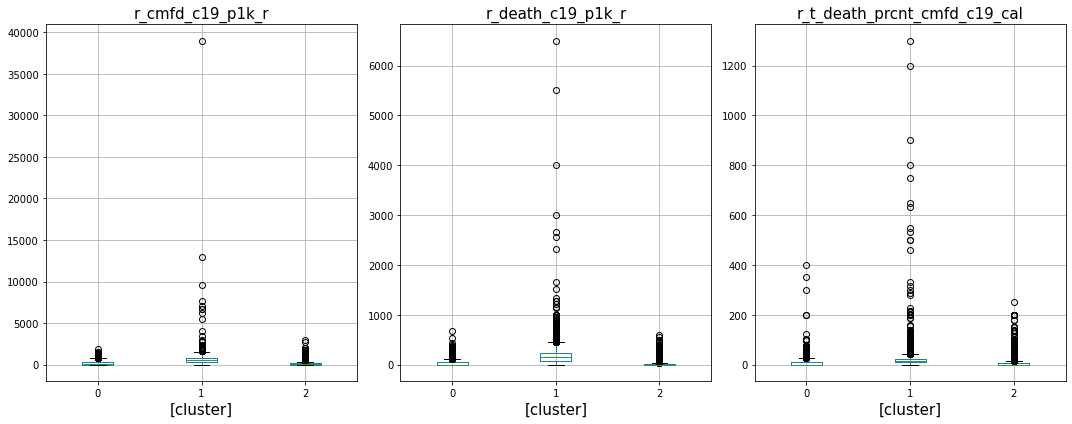

In [51]:
fig, axes = plt.subplots(1,3,figsize = (15,6))
data_merge_bf_std_c.loc[:,['cluster','r_cmfd_c19_p1k_r','r_death_c19_p1k_r', 'r_t_death_prcnt_cmfd_c19_cal']].\
boxplot(by='cluster',ax = axes)
fig.suptitle('')
fig.tight_layout()

plt.show()

In [52]:
#from the above plot we can see that NH belonging cluster 1 has comparatively larger value of
#covid related case and covid death followed by cluster 0 

#Cluster 1 - High risk
#Cluster 0 - medium risk 
#Cluster 2 - low risk 



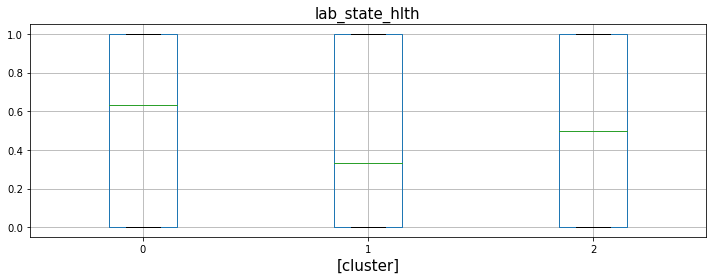

In [53]:
fig, axes = plt.subplots(1,1,figsize = (10,4))
data_merge_bf_std_c.loc[:,['cluster','lab_state_hlth']].\
boxplot(by='cluster',ax = axes)

fig.suptitle('')
fig.tight_layout()
plt.show()

In [54]:
#from the boxplot we can see that high risk cluster has the NH that has accessed the
#Laboratory which is of type State Health Dept lesser.

#we need to understand why this behaviour

/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes



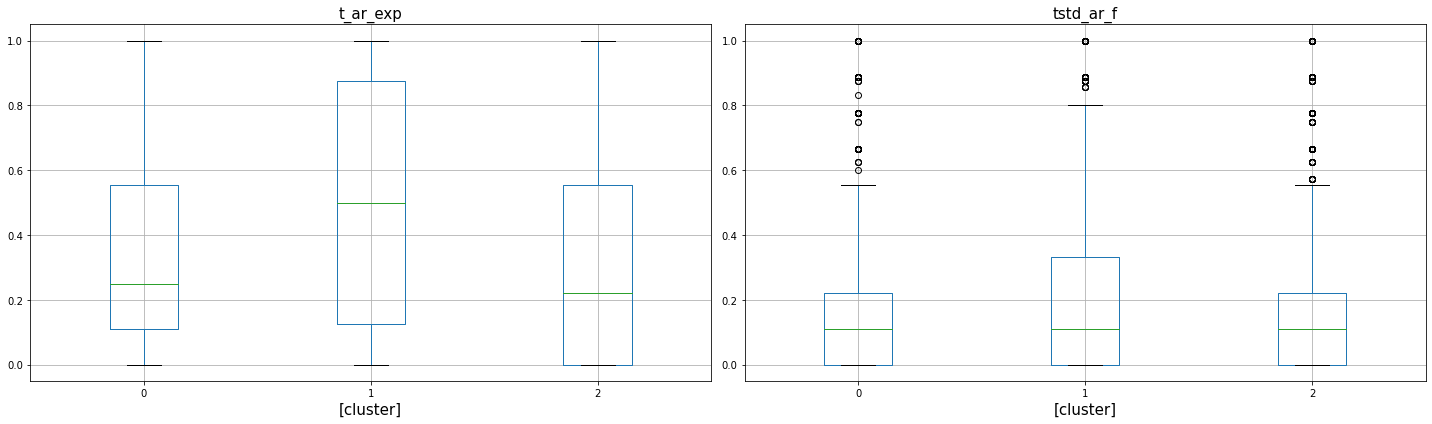

In [55]:
fig, axes = plt.subplots(1,2,figsize = (20,6))
data_merge_bf_std_c.loc[:,['cluster', 'tstd_ar_f', 't_ar_exp']].\
boxplot(by='cluster',ax = axes)

fig.suptitle('')
fig.tight_layout()
plt.show()


#         'Tested Asymptomatic Residents Facility-Wide After a New Case',
#         'Tested Asymptomatic Residents Without Known Exposure as Surveillance',


In [56]:
#even though cluster 1 is the High risk cluster in terms of covid case, they have still
#comparatively tested asymptotic resident more

/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes



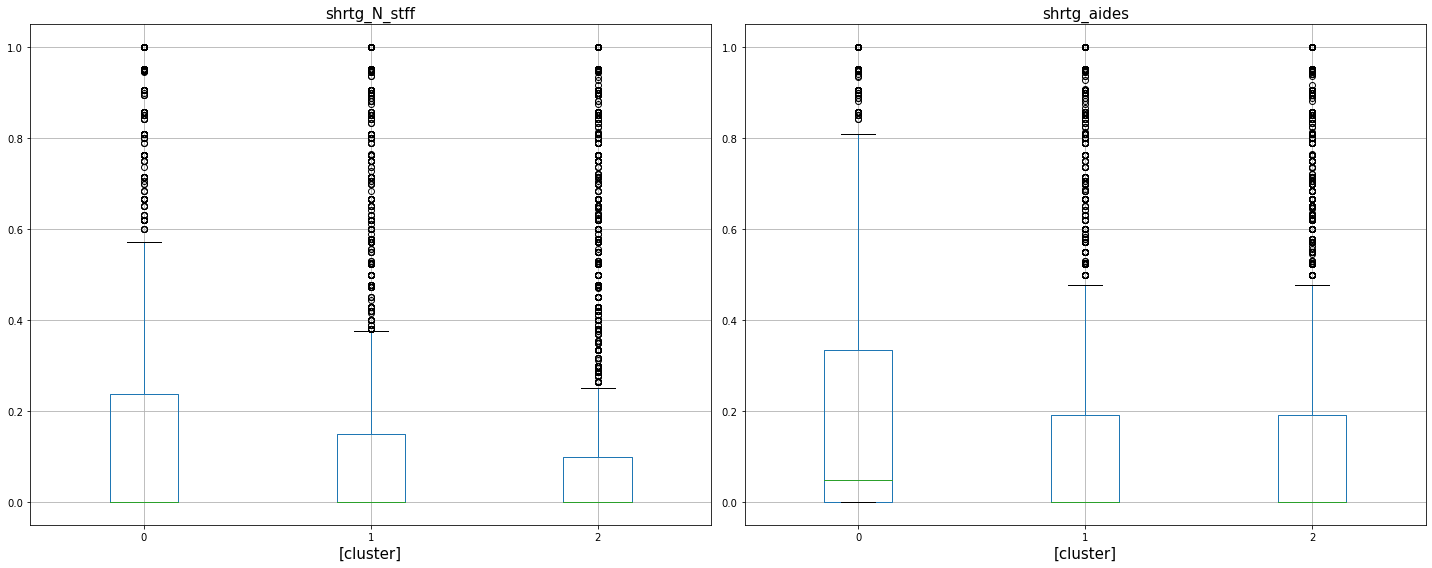

In [57]:
fig, axes = plt.subplots(1,2,figsize = (20,8))
data_merge_bf_std_c.loc[:,['cluster','shrtg_aides', 'shrtg_N_stff']].\
boxplot(by='cluster',ax = axes)

fig.suptitle('')
fig.tight_layout()
plt.show()

In [58]:
#interestingly even though larger cases are observed in cluster 1(high risk) but shortage of staff and aides
#are observed in cluster 0(medium risk) 

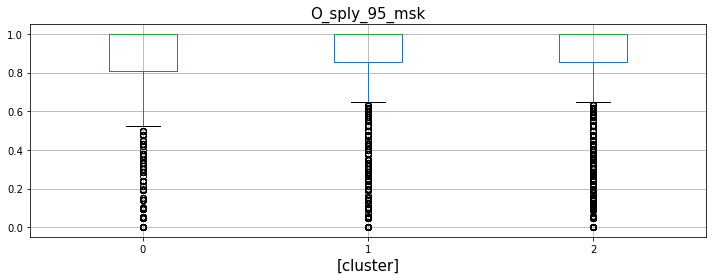

In [59]:
fig, axes = plt.subplots(1,1,figsize = (10,4))
data_merge_bf_std_c.loc[:,['cluster', 'O_sply_95_msk']].\
boxplot(by='cluster',ax = axes)

fig.suptitle('')
fig.tight_layout()
plt.show()

In [60]:
#As we observed earlier medium risk cluster faced shortage of staff and aides it also has
#comparatively lesser supplies of mask 

/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes



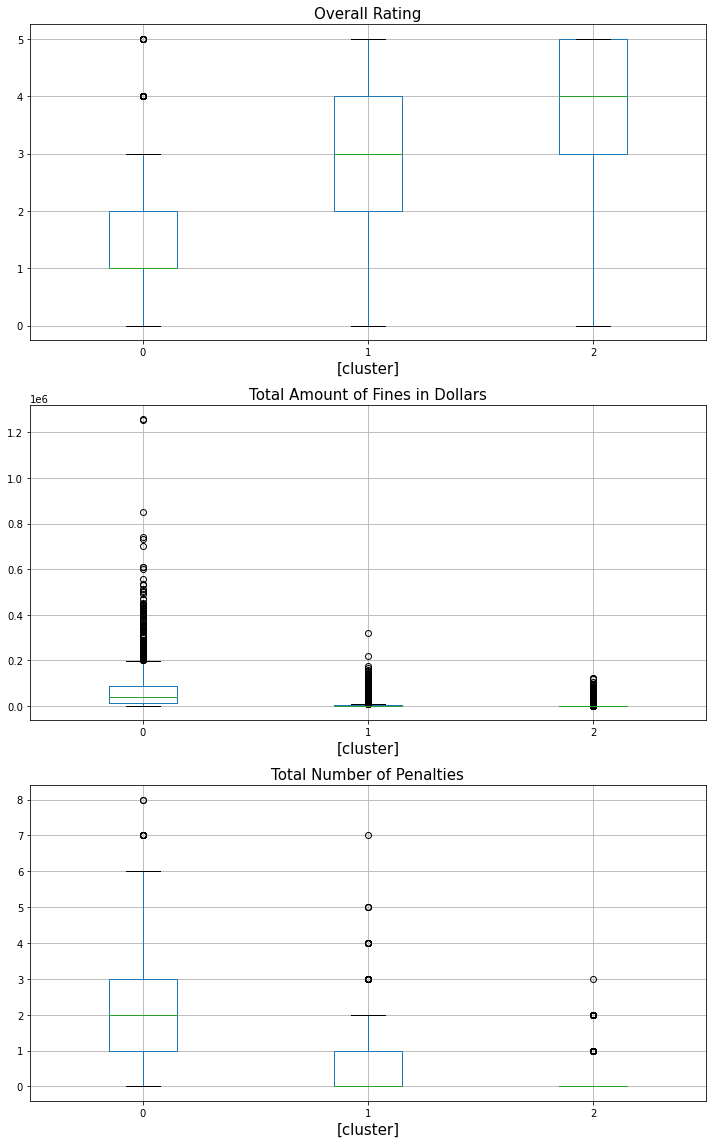

In [61]:
fig, axes = plt.subplots(3,1,figsize = (10,16))
data_merge_bf_std_c.loc[:,['cluster',  'Overall Rating', 
       'Total Amount of Fines in Dollars', 'Total Number of Penalties']].\
boxplot(by='cluster',ax = axes)

fig.suptitle('')
fig.tight_layout()
plt.show()

In [62]:
#medium risk cluster has low rating,more fines and number of penalties, which then is followed
#by high risk cluster 

## Adding Census data to nursing home data

In [63]:
import requests

#get data from census api
census_data = requests.get("https://api.census.gov/data/2019/acs/acs1/profile?get=NAME,DP02_0001E,DP02_0016E,DP02_0044E,DP02_0044PE,DP02_0053E,DP02_0053PE,DP03_0004E,DP03_0004PE,DP03_0062E,DP03_0063E,DP03_0088E,DP03_0099E,DP03_0099PE,DP03_0119PE,DP04_0045E,DP04_0045PE,DP04_0016E,DP04_0017E,DP04_0018E,DP05_0002E,DP05_0003E,DP04_0019E,DP05_0018E,DP05_0024E,DP05_0024PE,DP05_0064PE,DP05_0065PE,DP05_0066PE,DP05_0067PE,DP05_0068PE,DP05_0069PE,DP05_0070PE&for=county:*")
#check response code
print(census_data)
#check type
print(type(census_data.json()))

<Response [200]>
<class 'list'>


In [64]:
#save census data as csv
censusFile = open('census_data.csv', 'w')
censusFile.write(census_data.text)
censusFile.close()

In [65]:
#read in csv
census_df = pd.read_csv('census_data.csv',encoding = "ISO-8859-1")
census_df.reset_index(level = 0, inplace = True)
census_df.head()

index     [["NAME"  DP02_0001E  DP02_0016E   DP02_0044E  \
0  ["Jefferson County    Kentucky"    316174.0        2.37      15698.0   
1   ["Hennepin County   Minnesota"    517091.0        2.40      15712.0   
2    ["Olmsted County   Minnesota"     65635.0        2.37 -999999999.0   
3      ["Scott County   Minnesota"     51474.0        2.86 -999999999.0   
4   ["Faulkner County    Arkansas"     47389.0        2.55       4050.0   

   DP02_0044PE  DP02_0053E  DP02_0053PE  DP03_0004E  DP03_0004PE  ...  \
0      15698.0    173361.0     173361.0      382639         62.0  ...   
1      15712.0    307409.0     307409.0      709821         69.8  ...   
2 -999999999.0     37198.0      37198.0       86582         70.0  ...   
3 -999999999.0     41855.0      41855.0       85697         75.8  ...   
4       4050.0     37236.0      37236.0       61283         61.0  ...   

   DP05_0064PE  DP05_0065PE  DP05_0066PE  DP05_0067PE  DP05_0068PE  \
0         73.5         23.9          0.6          3.7          0.1   
1         75.5         15.3          1.8          8.4          0.2   
2         86.0          7.6          0.7          7.6          0.5   
3         87.2          6.2          1.6          7.2 -999999999.0   
4         84.6         14.0          0.9          1.8 -999999999.0   

   DP05_0069PE  DP05_0070PE  state  county]  Unnamed: 35  
0          0.8       766757     21     111]          NaN  
1          3.5      1265843     27     053]          NaN  
2          0.7       158293     27     109]          NaN  
3          2.4       149013     27     139]          NaN  
4          1.4       126007      5     045]          NaN  

[5 rows x 37 columns]

In [66]:
#rename census codes to english
col_names = {'index': 'county','[["NAME"': 'state_name','DP02_0001E': 'total_households', 'DP02_0016E': 'avg_household_size', 'DP02_0044E': 'num_grandparents_living_with_grandchildren', 'DP02_0044PE': 'percent_grandparents_living_with_grandchildren', 'DP02_0053E': 'num_children_in_school', 'DP02_0053PE': 'percent_children_in_school', 'DP03_0004E': 'num_civilians_employed', 'DP03_0004PE': 'percent_civilians_employed', 'DP03_0062E': 'median_household_income_dollars', 'DP03_0063E': 'mean_household_income_dollars', 'DP03_0088E': 'per_capita_income_dollars', 'DP03_0099E': 'civilian_pop_no_health_insurance', 'DP03_0099PE': 'percent_civilian_pop_no_health_insurance', 'DP03_0119PE': 'percent_families_below_poverty_line', 'DP04_0045E': 'occupied_housing_units', 'DP04_0045PE': 'percent_occupied_housing_units', 'DP04_0016E': 'total_housing_units', 'DP04_0017E': 'total_housing_units_2014_or_later', 'DP04_0018E': 'total_housing_units_2010_to_2013', 'DP05_0002E': 'male_pop', 'DP05_0003E': 'female_pop', 'DP04_0019E': 'total_housing_units_2000_to_2009', 'DP05_0018E': 'median_age', 'DP05_0024E': 'pop_65_and_over', 'DP05_0024PE': 'percent_pop_65_and_over', 'DP05_0064PE': 'percent_pop_white', 'DP05_0065PE': 'percent_pop_black', 'DP05_0066PE': 'percent_pop_native_american', 'DP05_0067PE': 'percent_pop_asian', 'DP05_0068PE': 'percent_pop_islander', 'DP05_0069PE': 'percent_pop_other', 'DP05_0070PE': 'percent_pop_hispanic_latino','state':'state_FIPS','county]':'county_FIPS','Unnamed: 35': 'Unnamed: 35'}
census_df = census_df.rename(columns = col_names)
#remove misc. characters in data
census_df['county'] = census_df['county'].replace(to_replace = r'\[\"', value = "", regex = True)
census_df['state_name'] = census_df['state_name'].replace(to_replace = r'\"', value = "", regex = True)
census_df['county_FIPS'] = census_df['county_FIPS'].replace(to_replace = r'\]', value = "", regex = True)
#remove last column
census_df = census_df.drop(['Unnamed: 35'], axis = 1)
#census data uses -999999999.0 as N/A, replace that
census_df = census_df.replace(to_replace = -999999999.0, value = '')
census_df.head()

county  state_name  total_households  avg_household_size  \
0  Jefferson County    Kentucky          316174.0                2.37   
1   Hennepin County   Minnesota          517091.0                2.40   
2    Olmsted County   Minnesota           65635.0                2.37   
3      Scott County   Minnesota           51474.0                2.86   
4   Faulkner County    Arkansas           47389.0                2.55   

  num_grandparents_living_with_grandchildren  \
0                                      15698   
1                                      15712   
2                                              
3                                              
4                                       4050   

  percent_grandparents_living_with_grandchildren  num_children_in_school  \
0                                          15698                173361.0   
1                                          15712                307409.0   
2                                                                37198.0   
3                                                                41855.0   
4                                           4050                 37236.0   

   percent_children_in_school  num_civilians_employed  \
0                    173361.0                  382639   
1                    307409.0                  709821   
2                     37198.0                   86582   
3                     41855.0                   85697   
4                     37236.0                   61283   

   percent_civilians_employed  ...  percent_pop_65_and_over  \
0                        62.0  ...                     16.7   
1                        69.8  ...                     14.5   
2                        70.0  ...                     16.2   
3                        75.8  ...                     11.2   
4                        61.0  ...                     12.8   

   percent_pop_white  percent_pop_black  percent_pop_native_american  \
0               73.5               23.9                          0.6   
1               75.5               15.3                          1.8   
2               86.0                7.6                          0.7   
3               87.2                6.2                          1.6   
4               84.6                 14                          0.9   

   percent_pop_asian  percent_pop_islander  percent_pop_other  \
0                3.7                   0.1                0.8   
1                8.4                   0.2                3.5   
2                7.6                   0.5                0.7   
3                7.2                                      2.4   
4                1.8                                      1.4   

   percent_pop_hispanic_latino  state_FIPS  county_FIPS  
0                       766757          21          111  
1                      1265843          27          053  
2                       158293          27          109  
3                       149013          27          139  
4                       126007           5          045  

[5 rows x 36 columns]

In [67]:
#add full FIPS column
#need to use loop because we can't cast a col as a type
#county FIPS is a string to preserve leading 0's
FIPS = []
for i in range(0, len(census_df['state_FIPS'])):
    FIPS.append(str(census_df['state_FIPS'][i]) + census_df['county_FIPS'][i])
census_df['FIPS'] = FIPS
census_df.head()

county  state_name  total_households  avg_household_size  \
0  Jefferson County    Kentucky          316174.0                2.37   
1   Hennepin County   Minnesota          517091.0                2.40   
2    Olmsted County   Minnesota           65635.0                2.37   
3      Scott County   Minnesota           51474.0                2.86   
4   Faulkner County    Arkansas           47389.0                2.55   

  num_grandparents_living_with_grandchildren  \
0                                      15698   
1                                      15712   
2                                              
3                                              
4                                       4050   

  percent_grandparents_living_with_grandchildren  num_children_in_school  \
0                                          15698                173361.0   
1                                          15712                307409.0   
2                                                                37198.0   
3                                                                41855.0   
4                                           4050                 37236.0   

   percent_children_in_school  num_civilians_employed  \
0                    173361.0                  382639   
1                    307409.0                  709821   
2                     37198.0                   86582   
3                     41855.0                   85697   
4                     37236.0                   61283   

   percent_civilians_employed  ...  percent_pop_white  percent_pop_black  \
0                        62.0  ...               73.5               23.9   
1                        69.8  ...               75.5               15.3   
2                        70.0  ...               86.0                7.6   
3                        75.8  ...               87.2                6.2   
4                        61.0  ...               84.6                 14   

   percent_pop_native_american  percent_pop_asian  percent_pop_islander  \
0                          0.6                3.7                   0.1   
1                          1.8                8.4                   0.2   
2                          0.7                7.6                   0.5   
3                          1.6                7.2                         
4                          0.9                1.8                         

   percent_pop_other  percent_pop_hispanic_latino  state_FIPS  county_FIPS  \
0                0.8                       766757          21          111   
1                3.5                      1265843          27          053   
2                0.7                       158293          27          109   
3                2.4                       149013          27          139   
4                1.4                       126007           5          045   

    FIPS  
0  21111  
1  27053  
2  27109  
3  27139  
4   5045  

[5 rows x 37 columns]

In [68]:
#connect to nursing home data csv to align clusters

#create ID
data_merge_bf_std_c['ID'] = data_merge_bf_std_c['County']+data_merge_bf_std_c['Provider State']
data_merge_bf_std_c.head()

Federal Provider Number Week Ending  lab_state_hlth  lab_prvt  lab_othr  \
0                  015009  2020-10-11             1.0       1.0       0.0   
1                  015010  2020-10-11             0.0       1.0       0.0   
2                  015012  2020-10-11             0.0       1.0       0.0   
3                  015014  2020-10-11             0.0       1.0       0.0   
4                  015015  2020-10-11             1.0       0.0       0.0   

   tstd_r_sngOsym  tstd_ar_u  tstd_ar_f  t_ar_exp  tstd_sbgrp_r  ...  \
0        0.111111   0.000000   0.333333  0.777778           0.0  ...   
1        0.666667   0.333333   0.166667  0.666667           0.0  ...   
2        0.222222   0.111111   0.222222  0.333333           0.0  ...   
3        0.000000   0.111111   0.000000  0.777778           0.0  ...   
4        0.000000   0.000000   0.000000  0.111111           0.0  ...   

   Overall Rating  Total Weighted Health Survey Score  \
0             5.0                               5.333   
1             4.0                              18.667   
2             3.0                              30.667   
3             4.0                              12.667   
4             4.0                              14.000   

   Total Amount of Fines in Dollars  Total Number of Penalties  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   
3                                 0                          0   
4                             29611                          2   

                           Provider Address  Provider City  Provider State  \
0                      701 MONROE STREET NW   RUSSELLVILLE              AL   
1                    260 WEST WALNUT STREET      SYLACAUGA              AL   
2                       380 WOODS COVE ROAD     SCOTTSBORO              AL   
3                  7755 FOURTH AVENUE SOUTH     BIRMINGHAM              AL   
4  6450 OLD TUSCALOOSA HIGHWAY   P O BOX 97       MC CALLA              AL   

   Provider Zip Code     County           ID  
0              35653   Franklin   FranklinAL  
1              35150  Talladega  TalladegaAL  
2              35768    Jackson    JacksonAL  
3              35206  Jefferson  JeffersonAL  
4              35111  Jefferson  JeffersonAL  

[5 rows x 62 columns]

In [69]:
#import county to FIPS code reference table I manually created
FIPS_lookup = pd.read_csv('county_FIPS_lookup.csv')

#merge nursing home data with FIPS lookup to get FIPS code
data_merge_bf_std_c = pd.merge(left = data_merge_bf_std_c, right = FIPS_lookup, left_on = 'ID', right_on = 'state_ID', how = 'left')
data_merge_bf_std_c = data_merge_bf_std_c.drop(['county_name','County Name Cleaned','state_ID','State','county_correct_spelling'], axis = 1)
data_merge_bf_std_c['countyFIPS'] = data_merge_bf_std_c['countyFIPS'].apply(np.int64)
data_merge_bf_std_c.head()

Federal Provider Number Week Ending  lab_state_hlth  lab_prvt  lab_othr  \
0                  015009  2020-10-11             1.0       1.0       0.0   
1                  015010  2020-10-11             0.0       1.0       0.0   
2                  015012  2020-10-11             0.0       1.0       0.0   
3                  015014  2020-10-11             0.0       1.0       0.0   
4                  015015  2020-10-11             1.0       0.0       0.0   

   tstd_r_sngOsym  tstd_ar_u  tstd_ar_f  t_ar_exp  tstd_sbgrp_r  ...  \
0        0.111111   0.000000   0.333333  0.777778           0.0  ...   
1        0.666667   0.333333   0.166667  0.666667           0.0  ...   
2        0.222222   0.111111   0.222222  0.333333           0.0  ...   
3        0.000000   0.111111   0.000000  0.777778           0.0  ...   
4        0.000000   0.000000   0.000000  0.111111           0.0  ...   

   Total Weighted Health Survey Score  Total Amount of Fines in Dollars  \
0                               5.333                                 0   
1                              18.667                                 0   
2                              30.667                                 0   
3                              12.667                                 0   
4                              14.000                             29611   

   Total Number of Penalties                          Provider Address  \
0                          0                      701 MONROE STREET NW   
1                          0                    260 WEST WALNUT STREET   
2                          0                       380 WOODS COVE ROAD   
3                          0                  7755 FOURTH AVENUE SOUTH   
4                          2  6450 OLD TUSCALOOSA HIGHWAY   P O BOX 97   

   Provider City  Provider State  Provider Zip Code     County           ID  \
0   RUSSELLVILLE              AL              35653   Franklin   FranklinAL   
1      SYLACAUGA              AL              35150  Talladega  TalladegaAL   
2     SCOTTSBORO              AL              35768    Jackson    JacksonAL   
3     BIRMINGHAM              AL              35206  Jefferson  JeffersonAL   
4       MC CALLA              AL              35111  Jefferson  JeffersonAL   

   countyFIPS  
0        1059  
1        1121  
2        1071  
3        1073  
4        1073  

[5 rows x 63 columns]

In [70]:
#merge nursinghome data with census data
census_df['FIPS'] = census_df['FIPS'].apply(np.int64)
data_merge_bf_std_c = pd.merge(left = data_merge_bf_std_c, right = census_df, left_on = 'countyFIPS', right_on = 'FIPS', how = 'left')
data_merge_bf_std_c.tail()

Federal Provider Number Week Ending  lab_state_hlth  lab_prvt  lab_othr  \
14897                  676482  2020-10-11        0.000000       1.0       0.0   
14898                  676483  2020-10-11        0.000000       1.0       0.0   
14899                  676485  2020-10-11        0.000000       1.0       0.0   
14900                  686123  2020-10-11        0.000000       1.0       0.0   
14901                  686124  2020-10-11        0.833333       1.0       0.0   

       tstd_r_sngOsym  tstd_ar_u  tstd_ar_f  t_ar_exp  tstd_sbgrp_r  ...  \
14897        0.000000   0.000000   0.000000  0.888889      0.000000  ...   
14898        0.000000   0.111111   0.000000  0.111111      0.000000  ...   
14899        0.000000   0.000000   0.000000  0.000000      1.000000  ...   
14900        0.000000   0.000000   0.000000  0.222222      0.111111  ...   
14901        0.222222   0.222222   0.555556  0.777778      0.000000  ...   

       percent_pop_white  percent_pop_black  percent_pop_native_american  \
14897               63.6               20.4                          0.9   
14898               62.1                 24                          1.1   
14899               70.4               11.5                          1.1   
14900               77.2               17.8                          0.4   
14901               77.2               17.8                          0.4   

       percent_pop_asian  percent_pop_islander  percent_pop_other  \
14897                7.9                   0.2                9.8   
14898                7.3                   0.3                8.2   
14899               17.6                   0.3                2.4   
14900                2.1                   0.1                4.5   
14901                2.1                   0.1                4.5   

       percent_pop_hispanic_latino  state_FIPS  county_FIPS     FIPS  
14897                    4713325.0        48.0          201  48201.0  
14898                    2635516.0        48.0          113  48113.0  
14899                    1034730.0        48.0          085  48085.0  
14900                    2716940.0        12.0          086  12086.0  
14901                    2716940.0        12.0          086  12086.0  

[5 rows x 100 columns]

In [71]:
census_df.columns

Index(['county', 'state_name', 'total_households', 'avg_household_size',
       'num_grandparents_living_with_grandchildren',
       'percent_grandparents_living_with_grandchildren',
       'num_children_in_school', 'percent_children_in_school',
       'num_civilians_employed', 'percent_civilians_employed',
       'median_household_income_dollars', 'mean_household_income_dollars',
       'per_capita_income_dollars', 'civilian_pop_no_health_insurance',
       'percent_civilian_pop_no_health_insurance',
       'percent_families_below_poverty_line', 'occupied_housing_units',
       'percent_occupied_housing_units', 'total_housing_units',
       'total_housing_units_2014_or_later', 'total_housing_units_2010_to_2013',
       'male_pop', 'female_pop', 'total_housing_units_2000_to_2009',
       'median_age', 'pop_65_and_over', 'percent_pop_65_and_over',
       'percent_pop_white', 'percent_pop_black', 'percent_pop_native_american',
       'percent_pop_asian', 'percent_pop_islander', 'percent_

/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes



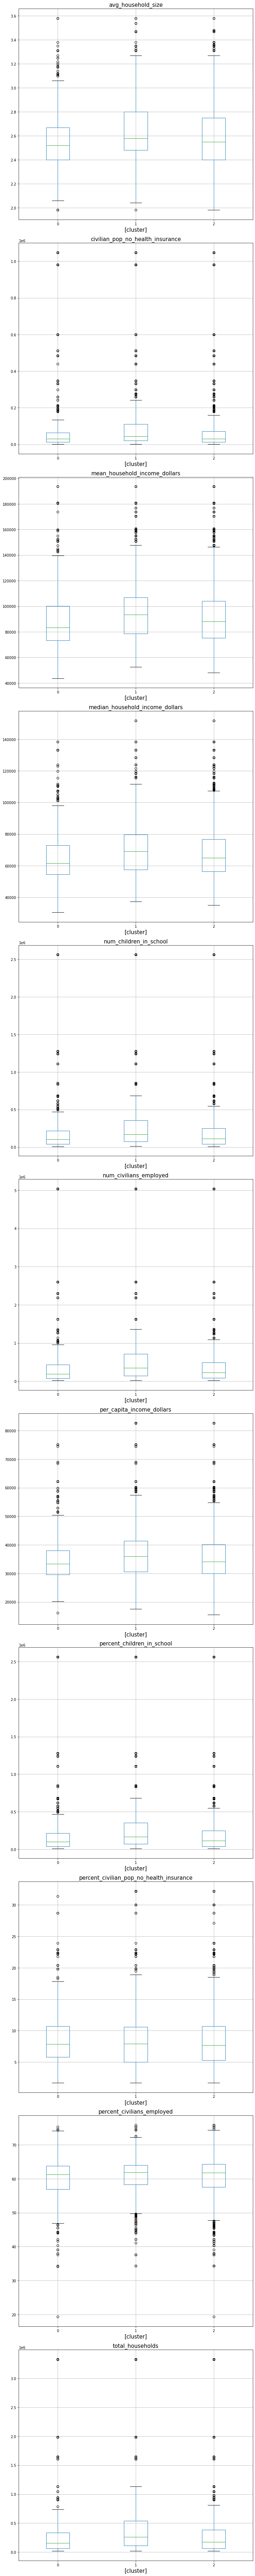

In [72]:
#all plots pt. 1
fig, axes = plt.subplots(11,1,figsize = (10,100))
data_merge_bf_std_c.loc[:,['cluster','total_households', 'avg_household_size',
       'num_grandparents_living_with_grandchildren',
       'percent_grandparents_living_with_grandchildren',
       'num_children_in_school', 'percent_children_in_school',
       'num_civilians_employed', 'percent_civilians_employed',
       'median_household_income_dollars', 'mean_household_income_dollars',
       'per_capita_income_dollars', 'civilian_pop_no_health_insurance',
       'percent_civilian_pop_no_health_insurance']].\
boxplot(by='cluster',ax = axes)

fig.suptitle('')
fig.tight_layout()
plt.show()

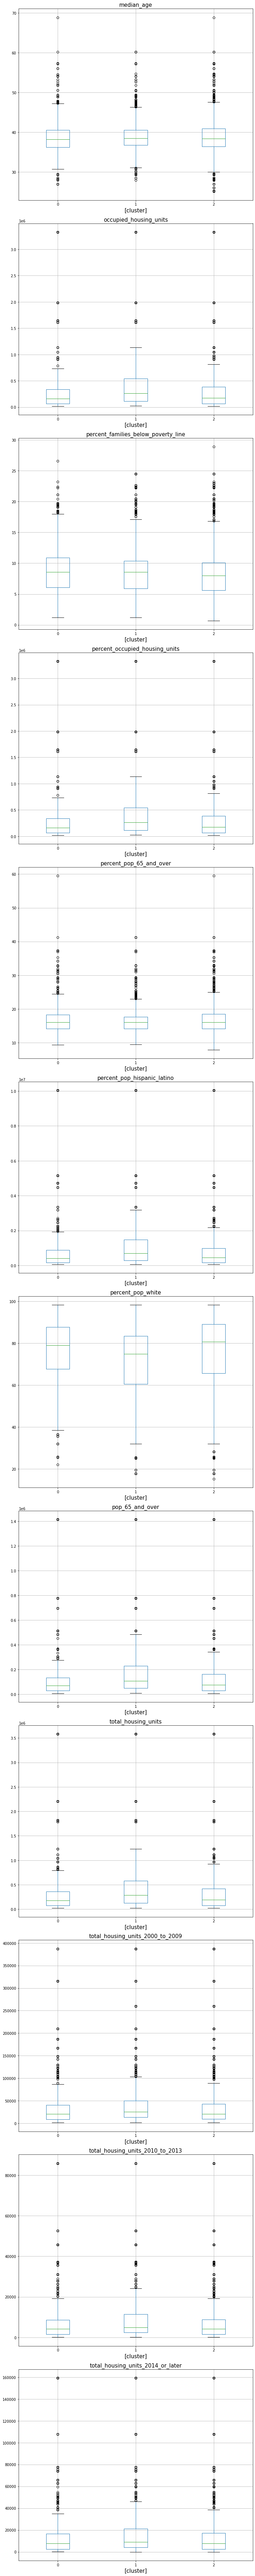

In [74]:
#all plots pt. 2
fig, axes = plt.subplots(12,1,figsize = (10, 100))
data_merge_bf_std_c.loc[:,['cluster','percent_families_below_poverty_line', 'occupied_housing_units',
       'percent_occupied_housing_units', 'total_housing_units',
       'total_housing_units_2014_or_later', 'total_housing_units_2010_to_2013',
       'total_housing_units_2000_to_2009',
       'median_age', 'pop_65_and_over', 'percent_pop_65_and_over',
       'percent_pop_white', 'percent_pop_black', 'percent_pop_native_american',
       'percent_pop_asian', 'percent_pop_islander', 'percent_pop_other',
       'percent_pop_hispanic_latino']].\
boxplot(by='cluster',ax = axes)

fig.suptitle('')
fig.tight_layout()
plt.show()

/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning:

When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes



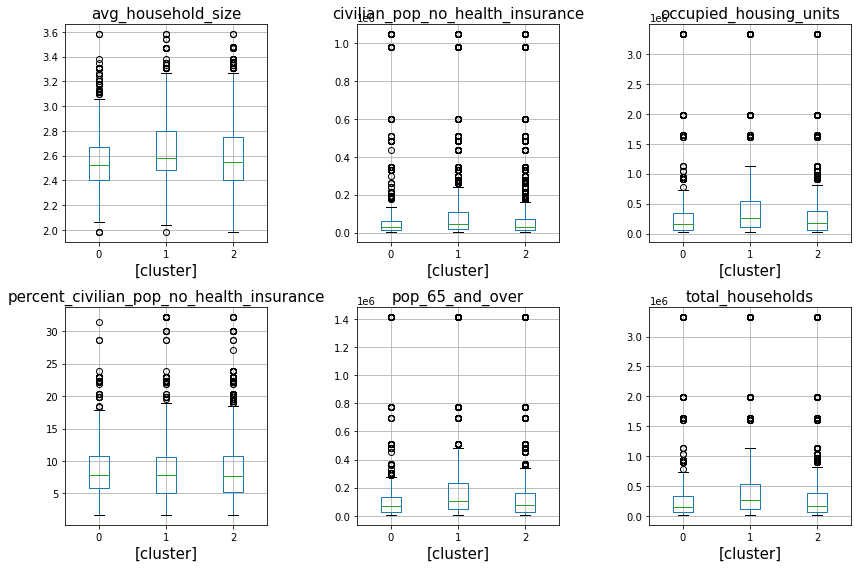

In [75]:
#informative plots
fig, axes = plt.subplots(2,3,figsize = (12,8))
data_merge_bf_std_c.loc[:,['cluster', 'avg_household_size','total_households','civilian_pop_no_health_insurance',
        'percent_civilian_pop_no_health_insurance','occupied_housing_units',
        'pop_65_and_over']].\
boxplot(by='cluster',ax = axes)

fig.suptitle('')
fig.tight_layout()
plt.show()

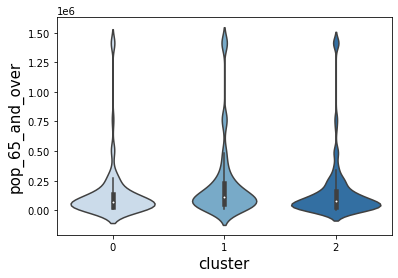

In [76]:
# Use a color palette
sns.violinplot( x=data_merge_bf_std_c["cluster"], y=data_merge_bf_std_c['pop_65_and_over'], palette="Blues")


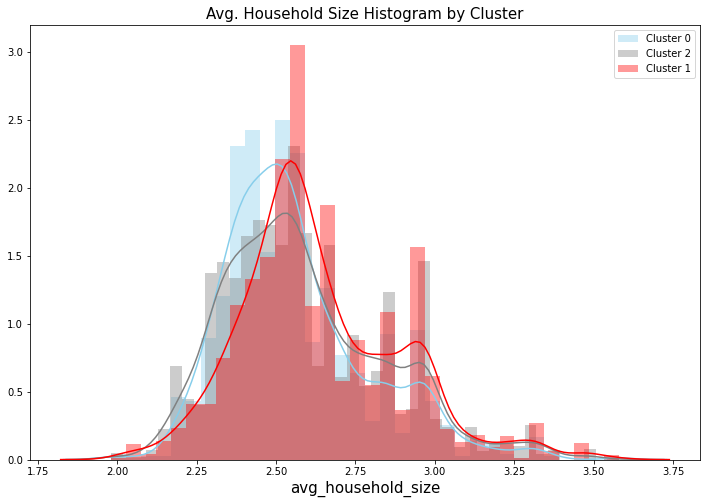

In [77]:
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(12,8))
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='0']['avg_household_size'] , color="skyblue", label="Cluster 0")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='2']['avg_household_size'] , color="grey", label="Cluster 2")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='1']['avg_household_size'] , color="red", label="Cluster 1")
plt.title("Avg. Household Size Histogram by Cluster")
plt.legend()
plt.show()

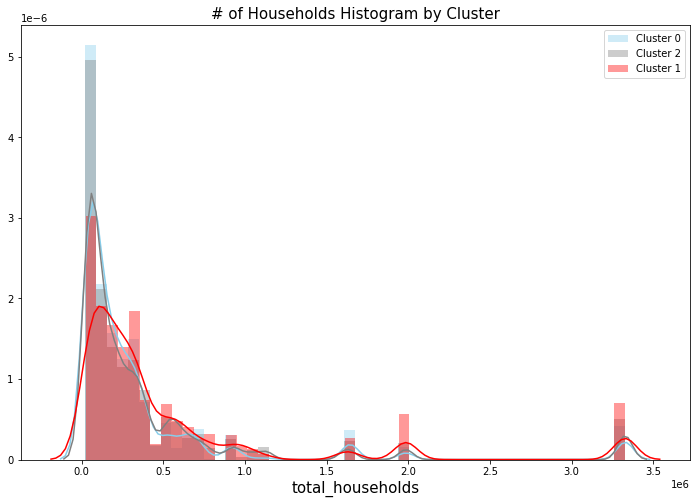

In [78]:
fig, ax = pyplot.subplots(figsize=(12,8))
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='0']['total_households'] , color="skyblue", label="Cluster 0")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='2']['total_households'] , color="grey", label="Cluster 2")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='1']['total_households'] , color="red", label="Cluster 1")
plt.title("# of Households Histogram by Cluster")
plt.legend()

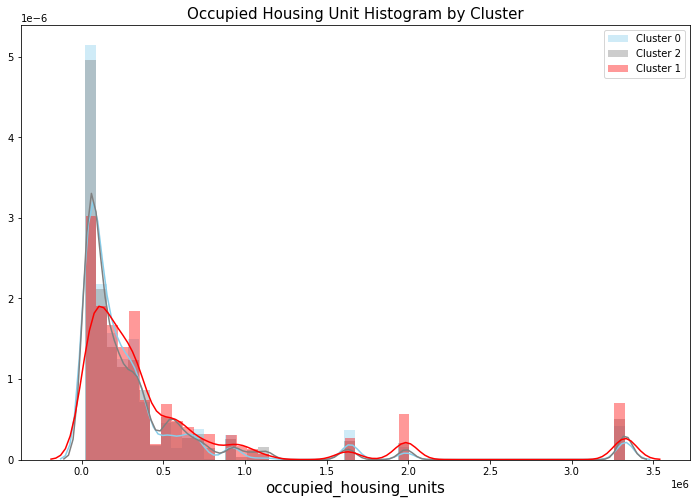

In [79]:
fig, ax = pyplot.subplots(figsize=(12,8))

sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='0']['occupied_housing_units'] , color="skyblue", label="Cluster 0")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='2']['occupied_housing_units'] , color="grey", label="Cluster 2")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='1']['occupied_housing_units'] , color="red", label="Cluster 1")
plt.title("Occupied Housing Unit Histogram by Cluster")
plt.legend()

From the above three plots, we can see that cluster 1 facilities are in regions where the average household size is larger, there are more housing units, and more occupied housing units. We can infer that cluster 1 is generally in higher desity areas.

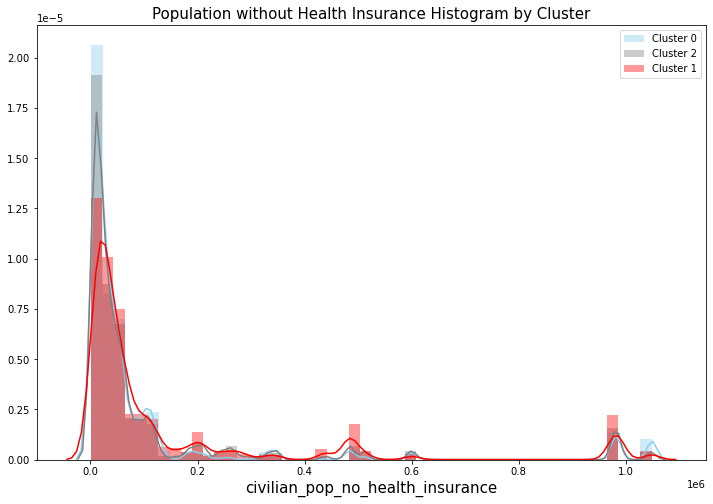

In [80]:
fig, ax = pyplot.subplots(figsize=(12,8))

sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='0']['civilian_pop_no_health_insurance'] , color="skyblue", label="Cluster 0")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='2']['civilian_pop_no_health_insurance'] , color="grey", label="Cluster 2")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='1']['civilian_pop_no_health_insurance'] , color="red", label="Cluster 1")
plt.title("Population without Health Insurance Histogram by Cluster")
plt.legend()

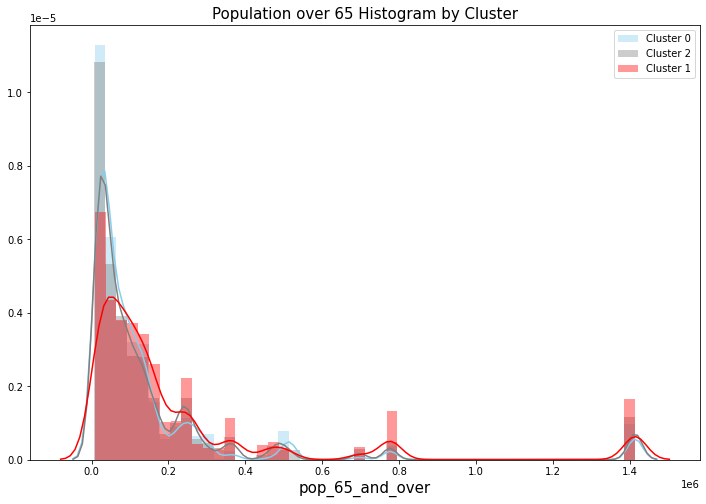

In [81]:
fig, ax = pyplot.subplots(figsize=(12,8))

sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='0']['pop_65_and_over'] , color="skyblue", label="Cluster 0")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='2']['pop_65_and_over'] , color="grey", label="Cluster 2")
sns.distplot( data_merge_bf_std_c[data_merge_bf_std_c["cluster"]=='1']['pop_65_and_over'] , color="red", label="Cluster 1")
plt.title("Population over 65 Histogram by Cluster")
plt.legend()

Text(0, 0.5, 'Population')

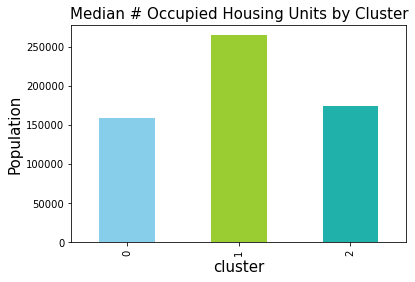

In [82]:
median_occ_housing = data_merge_bf_std_c.groupby('cluster')['occupied_housing_units'].median()

median_occ_housing.plot(kind='bar', color=['skyblue','yellowgreen','lightseagreen'])
plt.title("Median # Occupied Housing Units by Cluster")
plt.ylabel("Population")

Text(0, 0.5, 'Population')

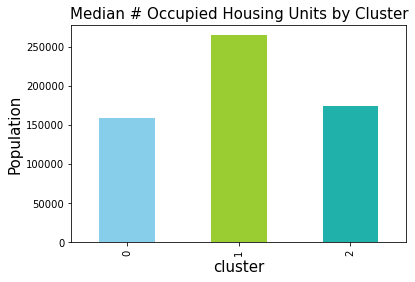

In [83]:
median_occ_housing = data_merge_bf_std_c.groupby('cluster')['occupied_housing_units'].median()

median_occ_housing.plot(kind='bar', color=['skyblue','yellowgreen','lightseagreen'])
plt.title("Median # Occupied Housing Units by Cluster")
plt.ylabel("Population")

Text(0, 0.5, 'Population')

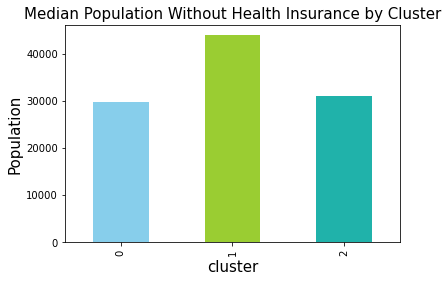

In [84]:
median_pop_no_hi = data_merge_bf_std_c.groupby('cluster')['civilian_pop_no_health_insurance'].median()

median_pop_no_hi.plot(kind='bar', color=['skyblue','yellowgreen','lightseagreen'])
plt.title("Median Population Without Health Insurance by Cluster")
plt.ylabel("Population")

Text(0, 0.5, 'Population')

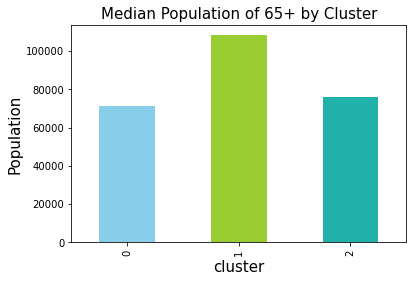

In [85]:
median_pop65 = data_merge_bf_std_c.groupby('cluster')['pop_65_and_over'].median()

median_pop65.plot(kind='bar', color=['skyblue','yellowgreen','lightseagreen'])
plt.title("Median Population of 65+ by Cluster")
plt.ylabel("Population")

## COVID Policy API

Unfortunately, we discovered we cannot connect to the policy API because the limit is 100 rows without an account. However, there is no option to create an account for Healthdata.gov, so the limit is effectively 100 rows for everyone. Below is the code to connect to the API and use regex to transform the data into a dataframe in case the limit is fixed in the future.

In [86]:
#policy_link = 'https://healthdata.gov/api/action/datastore/search.json?resource_id=8049ae6e-3e72-4fb4-a3b6-0fc8c85b6517&limit=5'
import io

#get data from policy api
policy_res = requests.get("https://healthdata.gov/api/action/datastore/search.json?resource_id=8049ae6e-3e72-4fb4-a3b6-0fc8c85b6517&limit=1000")
#check response code
print(policy_res)
#check type
print(type(policy_res.text))

<Response [200]>
<class 'str'>


In [87]:
#using regex to turn byte data from policy API to df
import re
    
txt = policy_res.text
x = re.findall(r'\"records\":\[\{.*', txt)
y = re.findall(r'\{.*\}', str(x))
state_id = re.findall(r'\{\"state_id":\"..\"', str(y))
county = re.findall(r'\,\"county\":\"[\w*\s*]{0,20}\"', str(y))
fips_code = re.findall(r'\,\"fips_code\":\"[\w]*\"', str(y))
policy_level = re.findall(r'\,\"policy_level\":\"[\w]*\"', str(y))
date = re.findall(r'\,\"date\":\"[\w]*\-[\w]*-[\w]*\"', str(y))
policy_type = re.findall(r'\,\"policy_type\":\"[\w*\s*]{0,1000}\/*\&*\,*\:*\_*\'*\\*\-*\(*\)*\.*\!*\#*\%*[\w*\s*]{0,1000}[\(\w*\-*\w*\)]*\"', str(y))
start_stop = re.findall(r'\,\"start_stop\":\"[start|stop]{0,20}\"', str(y))
comments = re.findall(r'\,\"comments\":\"[\w*\s*]{0,10000}\/*\&*\,*\:*\_*\'*\\*\-*\(*\)*\.*\!*\#*\%*[\w*\s*]{0,10000}\"*', str(y))
source = re.findall(r'\,\"source\":\"[\w*\s*]{0,10000}\/*\&*\,*\:*\_*\'*\\*\-*\(*\)*\.*\!*\#*[\w*\s*]{0,10000}\"*', str(y))
total_phases = re.findall(r'\,\"total_phases\":\"[\w]*\"', str(y))
entry_id = re.findall(r'\,\"entry_id\":\"[\w]*\"', str(y))

In [88]:
#checking regex, all printouts should have the same number if regex worked correctly
print(len(state_id))
print(len(county))
print(len(fips_code))
print(len(policy_level))
print(len(date))
print(len(policy_type))
print(len(start_stop))
print(len(comments))
print(len(source))
print(len(total_phases))
print(len(entry_id))

100
100
100
100
100
100
100
100
100
100
100


In [89]:
#combine regex into df
policy_df = pd.DataFrame({'state_id': state_id, 'county':county, 'fips_code':fips_code, 
                        'policy_level':policy_level, 'date':date, 'policy_type':policy_type,
                        'start_stop':start_stop, 'comments':comments, 'source':source,
                        'total_phases':total_phases, 'entry_id':entry_id})

#remove extra text from API
policy_df['state_id'] = policy_df['state_id'].replace(to_replace = r'\{\"state_id\":\"', value = "", regex = True)
policy_df['county'] = policy_df['county'].replace(to_replace = r'\,\"county\":\"', value = "", regex = True)
policy_df['fips_code'] = policy_df['fips_code'].replace(to_replace = r'\,\"fips_code\":\"', value = "", regex = True)
policy_df['policy_level'] = policy_df['policy_level'].replace(to_replace = r'\,\"policy_level\":\"', value = "", regex = True)
policy_df['date'] = policy_df['date'].replace(to_replace = r'\,\"date\":\"', value = "", regex = True)
policy_df['policy_type'] = policy_df['policy_type'].replace(to_replace = r'\,\"policy_type\":\"', value = "", regex = True)
policy_df['start_stop'] = policy_df['start_stop'].replace(to_replace = r'\,\"start_stop\":\"', value = "", regex = True)
policy_df['comments'] = policy_df['comments'].replace(to_replace = r'\,\"comments\":\"', value = "", regex = True)
policy_df['source'] = policy_df['source'].replace(to_replace = r'\,\"source\":\"', value = "", regex = True)
policy_df['total_phases'] = policy_df['total_phases'].replace(to_replace = r'\,\"total_phases\":\"', value = "", regex = True)
policy_df['entry_id'] = policy_df['entry_id'].replace(to_replace = r'\,\"entry_id\":\"', value = "", regex = True)
policy_df = policy_df.replace(to_replace = r'\"', value = "", regex = True)
policy_df.head()

state_id         county fips_code policy_level        date  \
0       TX    Cass County     48067       county  2020-04-02   
1       TX  Newton County     48351       county  2020-03-30   
2       FL                                 state  2020-03-17   
3       GA                                 state  2020-03-18   
4       HI                                 state  2020-06-05   

        policy_type start_stop  \
0  Shelter in Place      start   
1  Shelter in Place      start   
2  Childcare (K-12)      start   
3  Childcare (K-12)      start   
4    Food and Drink       stop   

                                            comments  \
0                           Cass County Policy Start   
1                         Newton County Policy Start   
2  Other measures and details for this policy inc...   
3  Other measures and details for this policy inc...   
4  Other measures and details for this policy inc...   

                              source total_phases entry_id  
0                           wikidata                     1  
1                           wikidata                     6  
2  BU COVID-19 State Policy Database                    11  
3  BU COVID-19 State Policy Database                    16  
4  BU COVID-19 State Policy Database                    21

In [90]:
# Import downloaded policy data instead
policy = pd.read_csv("state_policy_updates_20201120_0719.csv",parse_dates=['date'])

In [91]:
# Filter 'policy_level' as county 
policy_county=policy[policy['policy_level']=='county']
# Change 'fips_code' column to 'countyFIPS' to match with merged data
policy_county = policy_county.rename(columns = {'fips_code':'FIPS'})

In [92]:
# Policy data info.
policy_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1858 entries, 0 to 3506
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   state_id      1858 non-null   object        
 1   county        1858 non-null   object        
 2   FIPS          1858 non-null   float64       
 3   policy_level  1858 non-null   object        
 4   date          1858 non-null   datetime64[ns]
 5   policy_type   1858 non-null   object        
 6   start_stop    1858 non-null   object        
 7   comments      1858 non-null   object        
 8   source        1858 non-null   object        
 9   total_phases  409 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 159.7+ KB


In [93]:
print("There is a total of", len(policy_county.policy_type.unique()), "policy types for counties.")

There is a total of 23 policy types for counties.


In [94]:
# merged policy types with same meaning
policy_county_2 = policy_county.copy()
policy_county_2['policy_type'] = policy_county_2['policy_type'].astype(str).str.lower()
policy_county_2.replace({'policy_type': {'construction':'manufacturing',
                                 'bars':'food and drink',
                                 'agriculture':'manufacturing',
                                 'new phase':'manufacturing',
                                 'wholesale trade':'manufacturing',
                                 'day care':'childcare (k-12)',
                                 'public health advisory system':'phase 3',
                                 'personal care':'non-essential businesses',
                                 'entertainment':'non-essential businesses', 
                                 }}, inplace =True)
print("Now, there is a total of", len(policy_county_2.policy_type.unique()), "policy types for counties.")

Now, there is a total of 13 policy types for counties.


In [95]:
# How many time does each policy appear?
from nltk.probability import FreqDist
fdist = FreqDist()
for policies in policy_county_2.policy_type:
    fdist[policies.lower()]+=1
policy_frequency = dict(fdist)
policy_frequency

{'food and drink': 165,
 'childcare (k-12)': 118,
 'non-essential businesses': 216,
 'phase 3': 99,
 'shelter in place': 759,
 'phase 2': 61,
 'outdoor and recreation': 148,
 'manufacturing': 63,
 'phase 4': 17,
 'mask requirement': 135,
 'phase 5': 16,
 'houses of worship': 52,
 'phase 1': 9}

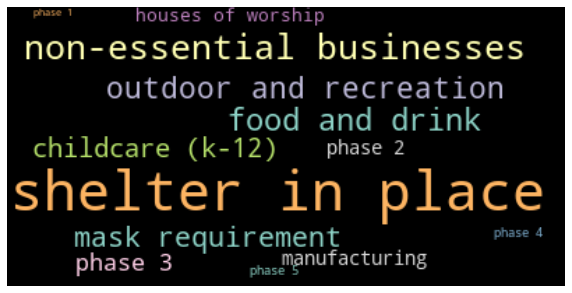

In [96]:
# Word cloud for policy types occurence
from wordcloud import WordCloud, ImageColorGenerator

wordcloud = WordCloud(max_words=15,max_font_size=50,colormap='Set3', background_color="black").generate_from_frequencies(policy_frequency)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(8,5))
plt.show()

In [97]:
# Make each policy type as dummy variable
from pandas.api.types import CategoricalDtype
policy_county_3 = policy_county_2.copy()
policy_county_3 = pd.concat([policy_county_3,pd.get_dummies(policy_county_3['policy_type'], prefix='policy_type: ')],axis=1)
policy_county_3.head(3)

state_id    county     FIPS policy_level       date  \
0       ME      York  23031.0       county 2020-06-01   
2       ND  Renville  38075.0       county 2020-09-03   
3       IL    Monroe  17133.0       county 2020-08-18   

                policy_type start_stop  \
0            food and drink      start   
2          childcare (k-12)      start   
3  non-essential businesses      start   

                                            comments  \
0  Policy_Details: restaurants in York County ten...   
2  Policy_Details: - Operate under heightened hyg...   
3  Policy_Details: meetings & social events are l...   

                                              source  total_phases  ...  \
0  sip_submission_form: https://www.maine.gov/gov...           3.0  ...   
2  sip_submission_form: https://ndresponse.gov/si...           5.0  ...   
3  sip_submission_form: https://www2.illinois.gov...           NaN  ...   

   policy_type: _manufacturing  policy_type: _mask requirement  \
0                            0                               0   
2                            0                               0   
3                            0                               0   

   policy_type: _non-essential businesses  \
0                                       0   
2                                       0   
3                                       1   

   policy_type: _outdoor and recreation  policy_type: _phase 1  \
0                                     0                      0   
2                                     0                      0   
3                                     0                      0   

   policy_type: _phase 2  policy_type: _phase 3  policy_type: _phase 4  \
0                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   

   policy_type: _phase 5  policy_type: _shelter in place  
0                      0                               0  
2                      0                               0  
3                      0                               0  

[3 rows x 23 columns]

In [98]:
# policy county data with only 'countyFIPS' and all the policy types
policy_county_4 = policy_county_3[['FIPS','policy_type: _food and drink', 'policy_type: _childcare (k-12)',
                                   'policy_type: _houses of worship','policy_type: _manufacturing', 'policy_type: _mask requirement',
                                   'policy_type: _non-essential businesses','policy_type: _outdoor and recreation', 'policy_type: _phase 1',
                                   'policy_type: _phase 2', 'policy_type: _phase 3','policy_type: _phase 4', 
                                   'policy_type: _phase 5', 'policy_type: _shelter in place']]
policy_county_4.head(3)

FIPS  policy_type: _food and drink  policy_type: _childcare (k-12)  \
0  23031.0                             1                               0   
2  38075.0                             0                               1   
3  17133.0                             0                               0   

   policy_type: _houses of worship  policy_type: _manufacturing  \
0                                0                            0   
2                                0                            0   
3                                0                            0   

   policy_type: _mask requirement  policy_type: _non-essential businesses  \
0                               0                                       0   
2                               0                                       0   
3                               0                                       1   

   policy_type: _outdoor and recreation  policy_type: _phase 1  \
0                                     0                      0   
2                                     0                      0   
3                                     0                      0   

   policy_type: _phase 2  policy_type: _phase 3  policy_type: _phase 4  \
0                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   

   policy_type: _phase 5  policy_type: _shelter in place  
0                      0                               0  
2                      0                               0  
3                      0                               0

In [99]:
# If same policy type appears more than once, it'll just count it as 1
policy_final = policy_county_4.groupby(['FIPS']).agg(lambda x:x.value_counts().index[0]).reset_index()
policy_final.head(3)

FIPS  policy_type: _food and drink  policy_type: _childcare (k-12)  \
0  2020.0                             0                               0   
1  2100.0                             0                               0   
2  2230.0                             0                               0   

   policy_type: _houses of worship  policy_type: _manufacturing  \
0                                0                            0   
1                                0                            0   
2                                0                            0   

   policy_type: _mask requirement  policy_type: _non-essential businesses  \
0                               0                                       0   
1                               0                                       0   
2                               0                                       0   

   policy_type: _outdoor and recreation  policy_type: _phase 1  \
0                                     0                      0   
1                                     0                      0   
2                                     0                      0   

   policy_type: _phase 2  policy_type: _phase 3  policy_type: _phase 4  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   

   policy_type: _phase 5  policy_type: _shelter in place  
0                      0                               1  
1                      0                               1  
2                      0                               1

In [100]:
print("There are", len(data_merge_bf_std_c.FIPS), "rows for FIPS code but", data_merge_bf_std_c.FIPS.isnull().sum(), "of them are missing.")

There are 14902 rows for FIPS code but 4478 of them are missing.


In [101]:
# Filter out missing values for 'countyFIPS' column
cluster_with_FIPS = data_merge_bf_std_c[data_merge_bf_std_c.FIPS.isnull()==False]
cluster_with_FIPS.head(3)

Federal Provider Number Week Ending  lab_state_hlth  lab_prvt  lab_othr  \
1                  015010  2020-10-11             0.0       1.0       0.0   
3                  015014  2020-10-11             0.0       1.0       0.0   
4                  015015  2020-10-11             1.0       0.0       0.0   

   tstd_r_sngOsym  tstd_ar_u  tstd_ar_f  t_ar_exp  tstd_sbgrp_r  ...  \
1        0.666667   0.333333   0.166667  0.666667           0.0  ...   
3        0.000000   0.111111   0.000000  0.777778           0.0  ...   
4        0.000000   0.000000   0.000000  0.111111           0.0  ...   

   percent_pop_white  percent_pop_black  percent_pop_native_american  \
1               65.5               34.4                                
3               53.1               43.9                          0.9   
4               53.1               43.9                          0.9   

   percent_pop_asian  percent_pop_islander  percent_pop_other  \
1                0.9                                      0.4   
3                2.2                   0.1                1.5   
4                2.2                   0.1                1.5   

   percent_pop_hispanic_latino  state_FIPS  county_FIPS    FIPS  
1                      79978.0         1.0          121  1121.0  
3                     658573.0         1.0          073  1073.0  
4                     658573.0         1.0          073  1073.0  

[3 rows x 100 columns]

In [102]:
# merge policy type data to cluster data by 'countyFIPS'
cluster_with_policy = pd.merge(cluster_with_FIPS,
                 policy_final[['FIPS', 'policy_type: _food and drink', 'policy_type: _houses of worship',
                                    'policy_type: _manufacturing', 'policy_type: _mask requirement',
                                    'policy_type: _non-essential businesses',
                                    'policy_type: _outdoor and recreation', 'policy_type: _phase 1',
                                    'policy_type: _phase 2', 'policy_type: _phase 3',
                                    'policy_type: _phase 4', 'policy_type: _phase 5',
                                    'policy_type: _shelter in place','policy_type: _childcare (k-12)']],
                                 on='FIPS', how='left')
#cluster_with_policy.tail(5)

In [103]:
# Proportion of each policy type by clusters
# 'policy_type: _houses of worship', 'policy_type: _childcare (k-12)',
# 'policy_type: _phase 1' and 'policy_type: _phase 5' are removed since they had no values for all 4 clusters
policy_type_list = ['policy_type: _food and drink',
                                    'policy_type: _manufacturing', 'policy_type: _mask requirement',
                                    'policy_type: _non-essential businesses',
                                    'policy_type: _outdoor and recreation',
                                    'policy_type: _phase 2', 'policy_type: _phase 3',
                                    'policy_type: _phase 4',
                                    'policy_type: _shelter in place']
policy_cluster = (cluster_with_policy.groupby('cluster')[policy_type_list].sum())/(cluster_with_policy.groupby('cluster')[policy_type_list].count())
policy_cluster

policy_type: _food and drink  policy_type: _manufacturing  \
cluster                                                              
0                            0.030928                     0.005155   
1                            0.029285                     0.086994   
2                            0.041498                     0.021529   

         policy_type: _mask requirement  \
cluster                                   
0                              0.113402   
1                              0.041344   
2                              0.118565   

         policy_type: _non-essential businesses  \
cluster                                           
0                                      0.029210   
1                                      0.016365   
2                                      0.014665   

         policy_type: _outdoor and recreation  policy_type: _phase 2  \
cluster                                                                
0                                    0.013746               0.013746   
1                                    0.027562               0.026701   
2                                    0.029017               0.007488   

         policy_type: _phase 3  policy_type: _phase 4  \
cluster                                                 
0                     0.139175               0.005155   
1                     0.056848               0.003445   
2                     0.137598               0.001560   

         policy_type: _shelter in place  
cluster                                  
0                              0.620275  
1                              0.544358  
2                              0.546334

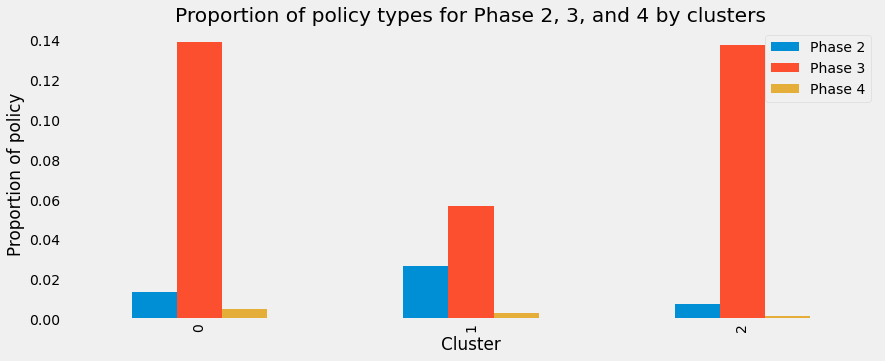

In [104]:
# Proportion of policy types for Phase 2, 3, and 4 by clusters
import matplotlib
matplotlib.style.use('fivethirtyeight') 
policy_cluster.reset_index().plot(
    x="cluster", y=['policy_type: _phase 2', 'policy_type: _phase 3',
                    'policy_type: _phase 4'], kind="bar",figsize=(13,5))
plt.title("Proportion of policy types for Phase 2, 3, and 4 by clusters")
plt.xlabel("Cluster")
plt.ylabel("Proportion of policy")
plt.legend(['Phase 2', 'Phase 3','Phase 4'])
plt.grid()
plt.show()

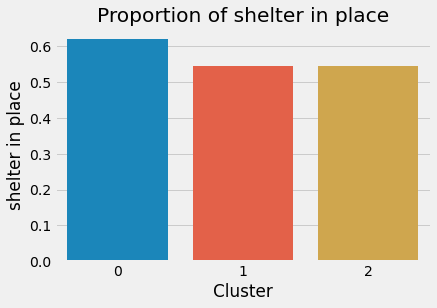

In [105]:
# Proportion of shelter in place
import seaborn as sns

sns.barplot(x = 'cluster', y = 'policy_type: _shelter in place', data = policy_cluster.reset_index())
plt.title("Proportion of shelter in place")
plt.xlabel("Cluster")
plt.ylabel("shelter in place")
plt.show()

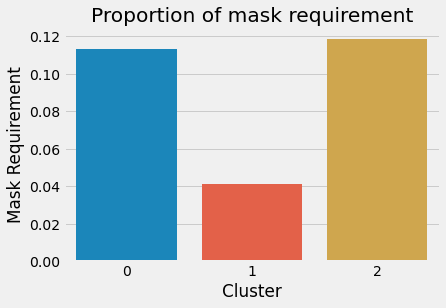

In [106]:
# Proportion of mask requirement
sns.barplot(x = 'cluster', y = 'policy_type: _mask requirement', data = policy_cluster.reset_index())
plt.title("Proportion of mask requirement")
plt.xlabel("Cluster")
plt.ylabel("Mask Requirement")
plt.show()

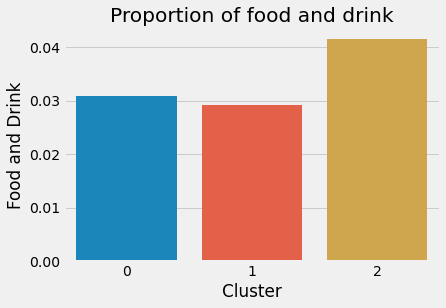

In [107]:
# Proportion of food and drink
sns.barplot(x = 'cluster', y = 'policy_type: _food and drink', data = policy_cluster.reset_index())
plt.title("Proportion of food and drink")
plt.xlabel("Cluster")
plt.ylabel("Food and Drink")
plt.show()

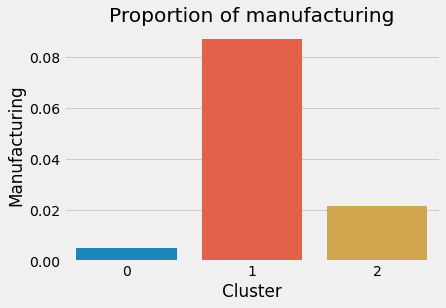

In [108]:
# Proportion of manufacturing
sns.barplot(x = 'cluster', y = 'policy_type: _manufacturing', data = policy_cluster.reset_index())
plt.title("Proportion of manufacturing")
plt.xlabel("Cluster")
plt.ylabel("Manufacturing")
plt.show()